In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import time

import nltk
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier
from functools import lru_cache
from pymorphy2 import MorphAnalyzer

np.random.seed(42)
random.seed(42)
%matplotlib inline

In [2]:
df = pd.read_csv('preprocessingf.csv')

In [3]:
df['cleaned_text'] = df['region'] + ' ' + df['cleaned_text']


In [4]:
df.target = df.target.apply(lambda x: 0 if x == 'Негативный' else (1 if x == 'Нейтральный' else 2))

In [5]:
df.head()

,address,name,rating,rubrics,text,aspects,region,cleaned_text,target,sym_len,...,specific_punctuation_count,uppercase_letters_count,rare_words,frequent_words,Позитивное,Негативное,Нейтральное,pos_f,negat_f,neut_f
0,Московская область,Мон Плезир,5.0,Гостиница,"Очень хорошая, уютная гостиницаРемонт тут дост...",гостиница nремонт номер количество свет персон...,Москва,Москва очень хороший уютный гостиницаремонт до...,2,421,...,5,8,3,13,1,1,1,1,1,1
1,Московская область,У Гаго,4.0,Быстрое питание,"Заказывали шашлык на работу, всё вкусно и цены...",шашлык работа цена заказ шашлык,Москва,Москва заказывать шашлык работа вкусно цена пр...,2,133,...,0,2,0,7,1,1,1,1,1,1
2,Москва,Чистая Планета,5.0,Магазин хозтоваров и бытовой химии;Средства ги...,Попробовала протестить пятновыводитель: теперь...,пятновыводитель nкондиционер бельё вид искусство,Москва,Москва попробовать протестить пятновыводитель ...,2,121,...,2,2,3,0,0,0,0,0,0,0
3,Санкт-Петербург,Городская больница Святого Праведного Иоанна К...,5.0,Родильный дом,Рожала тут первую доченьку в 2017 году. Персон...,доченька год персонал роддом стимуляция отделе...,Санкт-Петербург,Санкт-Петербург рожать первый доченька персона...,2,236,...,1,7,1,7,1,0,0,1,0,0
4,Белгородская область,Линия,5.0,Продуктовый гипермаркет;Универмаг,"Ассортимент большой,выбор есть и дешевого сегм...",ассортимент выбор сегмент парковка выпечка коф...,Белгородская область,Белгородская область ассортимент большой выбор...,2,240,...,0,5,0,10,1,1,1,1,1,1


In [6]:
df = df.drop(['address', 'rating','name', 'rubrics', 'Позитивное', 'Негативное','Нейтральное','aspects', 'region', 'text','rare_words','frequent_words'], axis=1)

In [8]:
# X = df['merged_text']
X = df.drop(['target'], axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [9]:
numeric_features = X_train.columns.tolist()
del numeric_features[0]

In [11]:
text_features = 'cleaned_text'

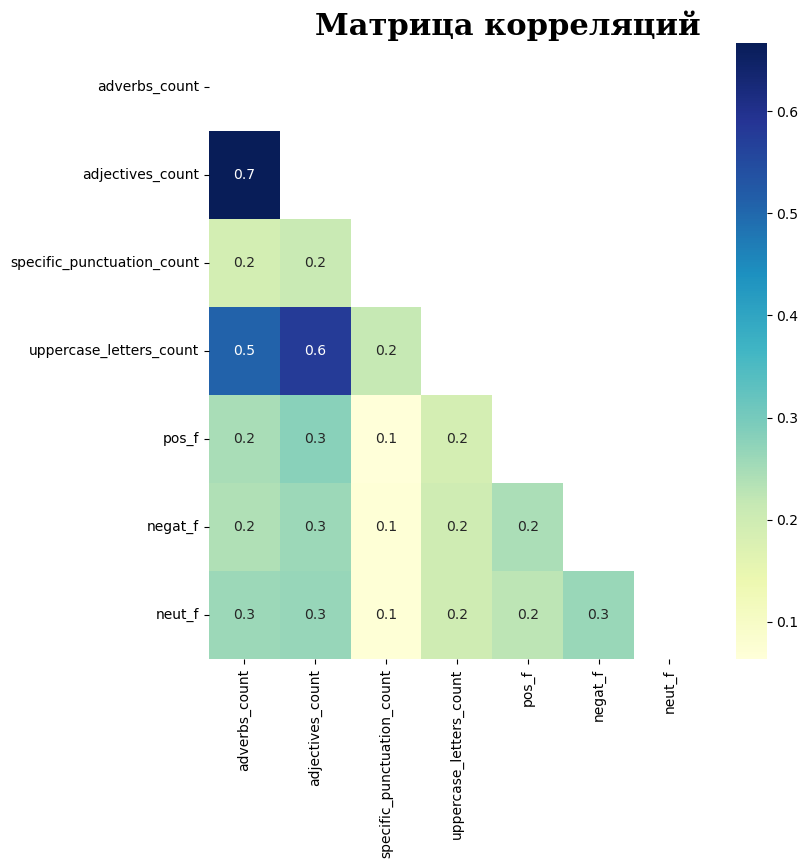

In [11]:
df_corr = df[numeric_features].corr().transpose()
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

color_palette = ["#5833ff","#da8829"]
mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Матрица корреляций",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

In [12]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [13]:
%%time
text_pipe = Pipeline([
    ('colext', TextSelector(text_features)),
    ('tfidf', TfidfVectorizer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=400))
])

numeric_pipe = Pipeline([
    ('wordext', NumberSelector(numeric_features)),
    ('wscaler', StandardScaler())
])


feature_union = FeatureUnion([
    ('text', text_pipe),
    ('words', numeric_pipe)
])
classifier = Pipeline([
    ('features', feature_union),
    ('ls', LinearSVC(multi_class='ovr', dual=False))
])
classifier.fit(X_train, y_train)
preds_svm = classifier.predict(X_test)

CPU times: total: 2min 58s
Wall time: 26.1 s


In [14]:
macro_f1 = f1_score(y_test, preds_svm, average='weighted')
print("f1:", macro_f1)

f1: 0.7739955456064065


Confusion matrix, without normalization
Normalized confusion matrix


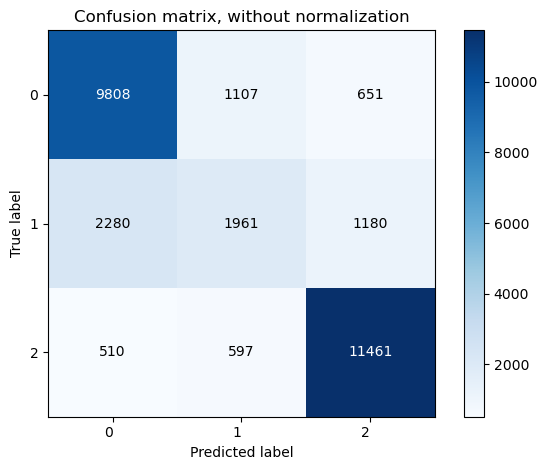

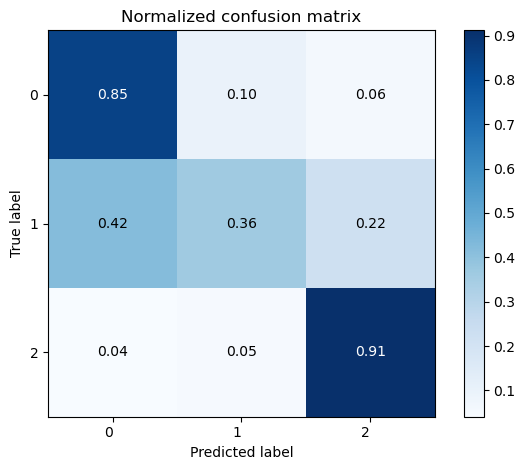

In [16]:
class_names = np.arange(len(np.unique(y_test)))

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    
    classes = class_names
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.xticks(rotation=0)
    
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, preds_svm, classes=class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test, preds_svm, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [17]:
%%time
text_pipe = Pipeline([
    ('colext', TextSelector(text_features)),
    ('tfidf', TfidfVectorizer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=400))
])


numeric_pipe = Pipeline([
    ('wordext', NumberSelector(numeric_features)),
    ('wscaler', StandardScaler())
])

feature_union = FeatureUnion([
    ('text', text_pipe),
    ('words', numeric_pipe)
])


classifier = Pipeline([
    ('features', feature_union),
    ('ctb', CatBoostClassifier(
        task_type="GPU",
        loss_function='MultiClass',
        iterations=10000,#5800
        learning_rate=0.6))
#         learning_rate=0.45))
])
classifier.fit(X_train, y_train)
preds_cb = classifier.predict(X_test)

0:	learn: 0.9040463	total: 456ms	remaining: 1h 15m 57s
1:	learn: 0.8419468	total: 702ms	remaining: 58m 28s
2:	learn: 0.8068135	total: 917ms	remaining: 50m 55s
3:	learn: 0.7810872	total: 1.15s	remaining: 47m 53s
4:	learn: 0.7585303	total: 1.4s	remaining: 46m 42s
5:	learn: 0.7406838	total: 1.65s	remaining: 45m 47s
6:	learn: 0.7262457	total: 1.84s	remaining: 43m 50s
7:	learn: 0.7147592	total: 2.04s	remaining: 42m 24s
8:	learn: 0.7028382	total: 2.25s	remaining: 41m 35s
9:	learn: 0.6933552	total: 2.45s	remaining: 40m 44s
10:	learn: 0.6840671	total: 2.65s	remaining: 40m 10s
11:	learn: 0.6759189	total: 2.85s	remaining: 39m 30s
12:	learn: 0.6687424	total: 3.05s	remaining: 39m 2s
13:	learn: 0.6618874	total: 3.23s	remaining: 38m 26s
14:	learn: 0.6549683	total: 3.49s	remaining: 38m 41s
15:	learn: 0.6481417	total: 3.7s	remaining: 38m 30s
16:	learn: 0.6426339	total: 3.91s	remaining: 38m 18s
17:	learn: 0.6378403	total: 4.09s	remaining: 37m 51s
18:	learn: 0.6327614	total: 4.28s	remaining: 37m 26s
19:

155:	learn: 0.4969249	total: 27.9s	remaining: 29m 19s
156:	learn: 0.4968614	total: 28s	remaining: 29m 15s
157:	learn: 0.4966321	total: 28.1s	remaining: 29m 13s
158:	learn: 0.4964873	total: 28.3s	remaining: 29m 11s
159:	learn: 0.4964409	total: 28.4s	remaining: 29m 8s
160:	learn: 0.4963846	total: 28.6s	remaining: 29m 5s
161:	learn: 0.4962535	total: 28.7s	remaining: 29m 2s
162:	learn: 0.4959884	total: 28.8s	remaining: 28m 59s
163:	learn: 0.4954861	total: 29s	remaining: 28m 57s
164:	learn: 0.4954420	total: 29.1s	remaining: 28m 56s
165:	learn: 0.4953721	total: 29.3s	remaining: 28m 53s
166:	learn: 0.4952709	total: 29.4s	remaining: 28m 50s
167:	learn: 0.4951785	total: 29.5s	remaining: 28m 47s
168:	learn: 0.4950266	total: 29.7s	remaining: 28m 45s
169:	learn: 0.4948829	total: 29.8s	remaining: 28m 42s
170:	learn: 0.4947412	total: 29.9s	remaining: 28m 39s
171:	learn: 0.4946707	total: 30.1s	remaining: 28m 37s
172:	learn: 0.4945324	total: 30.2s	remaining: 28m 35s
173:	learn: 0.4942742	total: 30.4s	

309:	learn: 0.4759280	total: 49.7s	remaining: 25m 54s
310:	learn: 0.4758777	total: 49.9s	remaining: 25m 53s
311:	learn: 0.4757862	total: 50s	remaining: 25m 52s
312:	learn: 0.4757295	total: 50.1s	remaining: 25m 51s
313:	learn: 0.4755297	total: 50.3s	remaining: 25m 50s
314:	learn: 0.4753460	total: 50.4s	remaining: 25m 49s
315:	learn: 0.4752954	total: 50.5s	remaining: 25m 48s
316:	learn: 0.4752572	total: 50.7s	remaining: 25m 47s
317:	learn: 0.4752171	total: 50.8s	remaining: 25m 46s
318:	learn: 0.4751672	total: 50.9s	remaining: 25m 45s
319:	learn: 0.4750769	total: 51.1s	remaining: 25m 45s
320:	learn: 0.4750111	total: 51.2s	remaining: 25m 44s
321:	learn: 0.4746956	total: 51.4s	remaining: 25m 45s
322:	learn: 0.4746675	total: 51.5s	remaining: 25m 44s
323:	learn: 0.4746459	total: 51.7s	remaining: 25m 43s
324:	learn: 0.4745387	total: 51.8s	remaining: 25m 42s
325:	learn: 0.4745050	total: 51.9s	remaining: 25m 41s
326:	learn: 0.4744657	total: 52.1s	remaining: 25m 40s
327:	learn: 0.4740399	total: 5

463:	learn: 0.4637088	total: 1m 11s	remaining: 24m 22s
464:	learn: 0.4636683	total: 1m 11s	remaining: 24m 22s
465:	learn: 0.4635492	total: 1m 11s	remaining: 24m 21s
466:	learn: 0.4635202	total: 1m 11s	remaining: 24m 21s
467:	learn: 0.4635005	total: 1m 11s	remaining: 24m 20s
468:	learn: 0.4634423	total: 1m 11s	remaining: 24m 20s
469:	learn: 0.4634156	total: 1m 11s	remaining: 24m 19s
470:	learn: 0.4633908	total: 1m 12s	remaining: 24m 18s
471:	learn: 0.4633393	total: 1m 12s	remaining: 24m 18s
472:	learn: 0.4633183	total: 1m 12s	remaining: 24m 17s
473:	learn: 0.4630731	total: 1m 12s	remaining: 24m 17s
474:	learn: 0.4630491	total: 1m 12s	remaining: 24m 16s
475:	learn: 0.4630239	total: 1m 12s	remaining: 24m 15s
476:	learn: 0.4628020	total: 1m 12s	remaining: 24m 16s
477:	learn: 0.4624040	total: 1m 13s	remaining: 24m 16s
478:	learn: 0.4623621	total: 1m 13s	remaining: 24m 15s
479:	learn: 0.4623036	total: 1m 13s	remaining: 24m 15s
480:	learn: 0.4621911	total: 1m 13s	remaining: 24m 14s
481:	learn

613:	learn: 0.4549616	total: 1m 30s	remaining: 23m 10s
614:	learn: 0.4549395	total: 1m 31s	remaining: 23m 10s
615:	learn: 0.4548618	total: 1m 31s	remaining: 23m 10s
616:	learn: 0.4548337	total: 1m 31s	remaining: 23m 10s
617:	learn: 0.4548009	total: 1m 31s	remaining: 23m 10s
618:	learn: 0.4547061	total: 1m 31s	remaining: 23m 10s
619:	learn: 0.4546851	total: 1m 31s	remaining: 23m 10s
620:	learn: 0.4546311	total: 1m 32s	remaining: 23m 10s
621:	learn: 0.4546087	total: 1m 32s	remaining: 23m 10s
622:	learn: 0.4544689	total: 1m 32s	remaining: 23m 11s
623:	learn: 0.4544354	total: 1m 32s	remaining: 23m 11s
624:	learn: 0.4544071	total: 1m 32s	remaining: 23m 11s
625:	learn: 0.4543790	total: 1m 32s	remaining: 23m 11s
626:	learn: 0.4543617	total: 1m 33s	remaining: 23m 11s
627:	learn: 0.4543364	total: 1m 33s	remaining: 23m 11s
628:	learn: 0.4543172	total: 1m 33s	remaining: 23m 10s
629:	learn: 0.4541629	total: 1m 33s	remaining: 23m 10s
630:	learn: 0.4541406	total: 1m 33s	remaining: 23m 10s
631:	learn

763:	learn: 0.4479169	total: 1m 51s	remaining: 22m 25s
764:	learn: 0.4478798	total: 1m 51s	remaining: 22m 24s
765:	learn: 0.4478610	total: 1m 51s	remaining: 22m 24s
766:	learn: 0.4478191	total: 1m 51s	remaining: 22m 24s
767:	learn: 0.4476718	total: 1m 51s	remaining: 22m 23s
768:	learn: 0.4476516	total: 1m 51s	remaining: 22m 23s
769:	learn: 0.4476237	total: 1m 52s	remaining: 22m 23s
770:	learn: 0.4476015	total: 1m 52s	remaining: 22m 22s
771:	learn: 0.4475750	total: 1m 52s	remaining: 22m 22s
772:	learn: 0.4475458	total: 1m 52s	remaining: 22m 21s
773:	learn: 0.4475090	total: 1m 52s	remaining: 22m 21s
774:	learn: 0.4474730	total: 1m 52s	remaining: 22m 21s
775:	learn: 0.4474452	total: 1m 52s	remaining: 22m 20s
776:	learn: 0.4474264	total: 1m 52s	remaining: 22m 20s
777:	learn: 0.4473406	total: 1m 53s	remaining: 22m 20s
778:	learn: 0.4473004	total: 1m 53s	remaining: 22m 19s
779:	learn: 0.4470598	total: 1m 53s	remaining: 22m 19s
780:	learn: 0.4470379	total: 1m 53s	remaining: 22m 19s
781:	learn

915:	learn: 0.4400462	total: 2m 10s	remaining: 21m 36s
916:	learn: 0.4400031	total: 2m 10s	remaining: 21m 36s
917:	learn: 0.4399862	total: 2m 11s	remaining: 21m 36s
918:	learn: 0.4399037	total: 2m 11s	remaining: 21m 36s
919:	learn: 0.4398840	total: 2m 11s	remaining: 21m 35s
920:	learn: 0.4398521	total: 2m 11s	remaining: 21m 35s
921:	learn: 0.4398270	total: 2m 11s	remaining: 21m 35s
922:	learn: 0.4398036	total: 2m 11s	remaining: 21m 34s
923:	learn: 0.4397858	total: 2m 11s	remaining: 21m 34s
924:	learn: 0.4395778	total: 2m 11s	remaining: 21m 34s
925:	learn: 0.4395424	total: 2m 12s	remaining: 21m 34s
926:	learn: 0.4394043	total: 2m 12s	remaining: 21m 33s
927:	learn: 0.4393834	total: 2m 12s	remaining: 21m 33s
928:	learn: 0.4393530	total: 2m 12s	remaining: 21m 33s
929:	learn: 0.4393362	total: 2m 12s	remaining: 21m 33s
930:	learn: 0.4393118	total: 2m 12s	remaining: 21m 32s
931:	learn: 0.4392912	total: 2m 12s	remaining: 21m 32s
932:	learn: 0.4392705	total: 2m 12s	remaining: 21m 32s
933:	learn

1065:	learn: 0.4341228	total: 2m 30s	remaining: 21m 1s
1066:	learn: 0.4341001	total: 2m 30s	remaining: 21m 1s
1067:	learn: 0.4340758	total: 2m 30s	remaining: 21m 1s
1068:	learn: 0.4339336	total: 2m 30s	remaining: 21m 1s
1069:	learn: 0.4339156	total: 2m 31s	remaining: 21m 1s
1070:	learn: 0.4338978	total: 2m 31s	remaining: 21m
1071:	learn: 0.4338816	total: 2m 31s	remaining: 21m
1072:	learn: 0.4338515	total: 2m 31s	remaining: 21m
1073:	learn: 0.4337841	total: 2m 31s	remaining: 21m
1074:	learn: 0.4337586	total: 2m 31s	remaining: 21m
1075:	learn: 0.4337350	total: 2m 31s	remaining: 21m
1076:	learn: 0.4337184	total: 2m 32s	remaining: 20m 59s
1077:	learn: 0.4337004	total: 2m 32s	remaining: 20m 59s
1078:	learn: 0.4336349	total: 2m 32s	remaining: 20m 59s
1079:	learn: 0.4336008	total: 2m 32s	remaining: 20m 59s
1080:	learn: 0.4335836	total: 2m 32s	remaining: 20m 58s
1081:	learn: 0.4335466	total: 2m 32s	remaining: 20m 58s
1082:	learn: 0.4335262	total: 2m 32s	remaining: 20m 58s
1083:	learn: 0.433500

1213:	learn: 0.4275692	total: 2m 50s	remaining: 20m 36s
1214:	learn: 0.4275522	total: 2m 50s	remaining: 20m 36s
1215:	learn: 0.4275317	total: 2m 51s	remaining: 20m 36s
1216:	learn: 0.4275037	total: 2m 51s	remaining: 20m 36s
1217:	learn: 0.4274869	total: 2m 51s	remaining: 20m 36s
1218:	learn: 0.4274671	total: 2m 51s	remaining: 20m 36s
1219:	learn: 0.4274434	total: 2m 51s	remaining: 20m 36s
1220:	learn: 0.4274175	total: 2m 51s	remaining: 20m 36s
1221:	learn: 0.4273958	total: 2m 52s	remaining: 20m 36s
1222:	learn: 0.4273386	total: 2m 52s	remaining: 20m 36s
1223:	learn: 0.4271753	total: 2m 52s	remaining: 20m 35s
1224:	learn: 0.4271275	total: 2m 52s	remaining: 20m 35s
1225:	learn: 0.4271092	total: 2m 52s	remaining: 20m 35s
1226:	learn: 0.4270855	total: 2m 52s	remaining: 20m 35s
1227:	learn: 0.4270575	total: 2m 52s	remaining: 20m 35s
1228:	learn: 0.4269051	total: 2m 53s	remaining: 20m 35s
1229:	learn: 0.4268767	total: 2m 53s	remaining: 20m 34s
1230:	learn: 0.4268440	total: 2m 53s	remaining: 

1362:	learn: 0.4212801	total: 3m 12s	remaining: 20m 20s
1363:	learn: 0.4212612	total: 3m 12s	remaining: 20m 20s
1364:	learn: 0.4212416	total: 3m 12s	remaining: 20m 19s
1365:	learn: 0.4212059	total: 3m 12s	remaining: 20m 19s
1366:	learn: 0.4211445	total: 3m 13s	remaining: 20m 19s
1367:	learn: 0.4211247	total: 3m 13s	remaining: 20m 19s
1368:	learn: 0.4211016	total: 3m 13s	remaining: 20m 18s
1369:	learn: 0.4210852	total: 3m 13s	remaining: 20m 18s
1370:	learn: 0.4210641	total: 3m 13s	remaining: 20m 18s
1371:	learn: 0.4210238	total: 3m 13s	remaining: 20m 18s
1372:	learn: 0.4210036	total: 3m 13s	remaining: 20m 18s
1373:	learn: 0.4209854	total: 3m 14s	remaining: 20m 17s
1374:	learn: 0.4207283	total: 3m 14s	remaining: 20m 17s
1375:	learn: 0.4207026	total: 3m 14s	remaining: 20m 17s
1376:	learn: 0.4206830	total: 3m 14s	remaining: 20m 17s
1377:	learn: 0.4206619	total: 3m 14s	remaining: 20m 17s
1378:	learn: 0.4206421	total: 3m 14s	remaining: 20m 17s
1379:	learn: 0.4206086	total: 3m 14s	remaining: 

1511:	learn: 0.4159510	total: 3m 33s	remaining: 20m
1512:	learn: 0.4159339	total: 3m 34s	remaining: 20m
1513:	learn: 0.4159095	total: 3m 34s	remaining: 20m
1514:	learn: 0.4158740	total: 3m 34s	remaining: 20m
1515:	learn: 0.4157104	total: 3m 34s	remaining: 20m
1516:	learn: 0.4156783	total: 3m 34s	remaining: 19m 59s
1517:	learn: 0.4156472	total: 3m 34s	remaining: 19m 59s
1518:	learn: 0.4156287	total: 3m 34s	remaining: 19m 59s
1519:	learn: 0.4156059	total: 3m 34s	remaining: 19m 59s
1520:	learn: 0.4155896	total: 3m 35s	remaining: 19m 59s
1521:	learn: 0.4155673	total: 3m 35s	remaining: 19m 58s
1522:	learn: 0.4155484	total: 3m 35s	remaining: 19m 58s
1523:	learn: 0.4155333	total: 3m 35s	remaining: 19m 58s
1524:	learn: 0.4155026	total: 3m 35s	remaining: 19m 58s
1525:	learn: 0.4154328	total: 3m 35s	remaining: 19m 58s
1526:	learn: 0.4154105	total: 3m 35s	remaining: 19m 58s
1527:	learn: 0.4153890	total: 3m 36s	remaining: 19m 57s
1528:	learn: 0.4153700	total: 3m 36s	remaining: 19m 57s
1529:	learn:

1659:	learn: 0.4099511	total: 3m 55s	remaining: 19m 41s
1660:	learn: 0.4099289	total: 3m 55s	remaining: 19m 41s
1661:	learn: 0.4099060	total: 3m 55s	remaining: 19m 41s
1662:	learn: 0.4098908	total: 3m 55s	remaining: 19m 41s
1663:	learn: 0.4098626	total: 3m 55s	remaining: 19m 40s
1664:	learn: 0.4098434	total: 3m 55s	remaining: 19m 40s
1665:	learn: 0.4098292	total: 3m 56s	remaining: 19m 40s
1666:	learn: 0.4098138	total: 3m 56s	remaining: 19m 40s
1667:	learn: 0.4097843	total: 3m 56s	remaining: 19m 40s
1668:	learn: 0.4097697	total: 3m 56s	remaining: 19m 39s
1669:	learn: 0.4097538	total: 3m 56s	remaining: 19m 39s
1670:	learn: 0.4097351	total: 3m 56s	remaining: 19m 39s
1671:	learn: 0.4097207	total: 3m 56s	remaining: 19m 39s
1672:	learn: 0.4097024	total: 3m 56s	remaining: 19m 39s
1673:	learn: 0.4096841	total: 3m 57s	remaining: 19m 38s
1674:	learn: 0.4096596	total: 3m 57s	remaining: 19m 38s
1675:	learn: 0.4096267	total: 3m 57s	remaining: 19m 38s
1676:	learn: 0.4095980	total: 3m 57s	remaining: 

1807:	learn: 0.4049802	total: 4m 15s	remaining: 19m 18s
1808:	learn: 0.4049611	total: 4m 15s	remaining: 19m 17s
1809:	learn: 0.4049197	total: 4m 15s	remaining: 19m 17s
1810:	learn: 0.4049036	total: 4m 16s	remaining: 19m 17s
1811:	learn: 0.4048875	total: 4m 16s	remaining: 19m 17s
1812:	learn: 0.4048614	total: 4m 16s	remaining: 19m 17s
1813:	learn: 0.4048404	total: 4m 16s	remaining: 19m 17s
1814:	learn: 0.4047169	total: 4m 16s	remaining: 19m 16s
1815:	learn: 0.4046959	total: 4m 16s	remaining: 19m 16s
1816:	learn: 0.4046803	total: 4m 16s	remaining: 19m 16s
1817:	learn: 0.4046605	total: 4m 16s	remaining: 19m 16s
1818:	learn: 0.4046412	total: 4m 17s	remaining: 19m 16s
1819:	learn: 0.4046243	total: 4m 17s	remaining: 19m 16s
1820:	learn: 0.4046018	total: 4m 17s	remaining: 19m 16s
1821:	learn: 0.4045813	total: 4m 17s	remaining: 19m 16s
1822:	learn: 0.4045361	total: 4m 17s	remaining: 19m 15s
1823:	learn: 0.4045156	total: 4m 17s	remaining: 19m 15s
1824:	learn: 0.4044522	total: 4m 18s	remaining: 

1955:	learn: 0.4002096	total: 4m 35s	remaining: 18m 54s
1956:	learn: 0.4001871	total: 4m 36s	remaining: 18m 54s
1957:	learn: 0.4001710	total: 4m 36s	remaining: 18m 54s
1958:	learn: 0.4001557	total: 4m 36s	remaining: 18m 54s
1959:	learn: 0.4001390	total: 4m 36s	remaining: 18m 54s
1960:	learn: 0.4001263	total: 4m 36s	remaining: 18m 53s
1961:	learn: 0.4000715	total: 4m 36s	remaining: 18m 53s
1962:	learn: 0.4000516	total: 4m 36s	remaining: 18m 53s
1963:	learn: 0.4000361	total: 4m 37s	remaining: 18m 53s
1964:	learn: 0.3999650	total: 4m 37s	remaining: 18m 53s
1965:	learn: 0.3999517	total: 4m 37s	remaining: 18m 53s
1966:	learn: 0.3997855	total: 4m 37s	remaining: 18m 53s
1967:	learn: 0.3997620	total: 4m 37s	remaining: 18m 53s
1968:	learn: 0.3997065	total: 4m 37s	remaining: 18m 53s
1969:	learn: 0.3996661	total: 4m 37s	remaining: 18m 52s
1970:	learn: 0.3996525	total: 4m 38s	remaining: 18m 52s
1971:	learn: 0.3996339	total: 4m 38s	remaining: 18m 52s
1972:	learn: 0.3996175	total: 4m 38s	remaining: 

2103:	learn: 0.3944911	total: 4m 55s	remaining: 18m 30s
2104:	learn: 0.3944633	total: 4m 56s	remaining: 18m 30s
2105:	learn: 0.3943651	total: 4m 56s	remaining: 18m 30s
2106:	learn: 0.3943090	total: 4m 56s	remaining: 18m 30s
2107:	learn: 0.3942885	total: 4m 56s	remaining: 18m 29s
2108:	learn: 0.3942481	total: 4m 56s	remaining: 18m 29s
2109:	learn: 0.3941025	total: 4m 56s	remaining: 18m 29s
2110:	learn: 0.3940852	total: 4m 56s	remaining: 18m 29s
2111:	learn: 0.3940657	total: 4m 56s	remaining: 18m 29s
2112:	learn: 0.3940521	total: 4m 57s	remaining: 18m 29s
2113:	learn: 0.3940246	total: 4m 57s	remaining: 18m 29s
2114:	learn: 0.3939032	total: 4m 57s	remaining: 18m 29s
2115:	learn: 0.3938148	total: 4m 57s	remaining: 18m 28s
2116:	learn: 0.3937627	total: 4m 57s	remaining: 18m 28s
2117:	learn: 0.3936819	total: 4m 57s	remaining: 18m 28s
2118:	learn: 0.3936612	total: 4m 58s	remaining: 18m 28s
2119:	learn: 0.3936458	total: 4m 58s	remaining: 18m 28s
2120:	learn: 0.3936292	total: 4m 58s	remaining: 

2253:	learn: 0.3889020	total: 5m 16s	remaining: 18m 7s
2254:	learn: 0.3888532	total: 5m 16s	remaining: 18m 6s
2255:	learn: 0.3888245	total: 5m 16s	remaining: 18m 6s
2256:	learn: 0.3887800	total: 5m 16s	remaining: 18m 6s
2257:	learn: 0.3887624	total: 5m 16s	remaining: 18m 6s
2258:	learn: 0.3887455	total: 5m 16s	remaining: 18m 6s
2259:	learn: 0.3887318	total: 5m 17s	remaining: 18m 5s
2260:	learn: 0.3887161	total: 5m 17s	remaining: 18m 5s
2261:	learn: 0.3886877	total: 5m 17s	remaining: 18m 5s
2262:	learn: 0.3884779	total: 5m 17s	remaining: 18m 5s
2263:	learn: 0.3884482	total: 5m 17s	remaining: 18m 5s
2264:	learn: 0.3883826	total: 5m 17s	remaining: 18m 5s
2265:	learn: 0.3883670	total: 5m 17s	remaining: 18m 5s
2266:	learn: 0.3883494	total: 5m 18s	remaining: 18m 4s
2267:	learn: 0.3883352	total: 5m 18s	remaining: 18m 4s
2268:	learn: 0.3883153	total: 5m 18s	remaining: 18m 4s
2269:	learn: 0.3882996	total: 5m 18s	remaining: 18m 4s
2270:	learn: 0.3882732	total: 5m 18s	remaining: 18m 4s
2271:	lear

2401:	learn: 0.3839119	total: 5m 37s	remaining: 17m 48s
2402:	learn: 0.3838933	total: 5m 37s	remaining: 17m 47s
2403:	learn: 0.3838722	total: 5m 37s	remaining: 17m 47s
2404:	learn: 0.3838350	total: 5m 38s	remaining: 17m 47s
2405:	learn: 0.3838136	total: 5m 38s	remaining: 17m 47s
2406:	learn: 0.3837982	total: 5m 38s	remaining: 17m 47s
2407:	learn: 0.3837765	total: 5m 38s	remaining: 17m 47s
2408:	learn: 0.3837602	total: 5m 38s	remaining: 17m 47s
2409:	learn: 0.3837355	total: 5m 38s	remaining: 17m 47s
2410:	learn: 0.3837188	total: 5m 39s	remaining: 17m 47s
2411:	learn: 0.3837047	total: 5m 39s	remaining: 17m 47s
2412:	learn: 0.3836651	total: 5m 39s	remaining: 17m 46s
2413:	learn: 0.3836402	total: 5m 39s	remaining: 17m 46s
2414:	learn: 0.3836278	total: 5m 39s	remaining: 17m 46s
2415:	learn: 0.3836118	total: 5m 39s	remaining: 17m 46s
2416:	learn: 0.3836006	total: 5m 39s	remaining: 17m 46s
2417:	learn: 0.3835442	total: 5m 40s	remaining: 17m 46s
2418:	learn: 0.3835255	total: 5m 40s	remaining: 

2548:	learn: 0.3790101	total: 5m 59s	remaining: 17m 32s
2549:	learn: 0.3789139	total: 6m	remaining: 17m 32s
2550:	learn: 0.3788904	total: 6m	remaining: 17m 31s
2551:	learn: 0.3788762	total: 6m	remaining: 17m 31s
2552:	learn: 0.3788577	total: 6m	remaining: 17m 31s
2553:	learn: 0.3788399	total: 6m	remaining: 17m 31s
2554:	learn: 0.3788253	total: 6m	remaining: 17m 31s
2555:	learn: 0.3787070	total: 6m	remaining: 17m 31s
2556:	learn: 0.3786924	total: 6m 1s	remaining: 17m 31s
2557:	learn: 0.3786802	total: 6m 1s	remaining: 17m 31s
2558:	learn: 0.3786570	total: 6m 1s	remaining: 17m 31s
2559:	learn: 0.3786375	total: 6m 1s	remaining: 17m 30s
2560:	learn: 0.3785857	total: 6m 1s	remaining: 17m 30s
2561:	learn: 0.3785315	total: 6m 1s	remaining: 17m 30s
2562:	learn: 0.3785182	total: 6m 2s	remaining: 17m 30s
2563:	learn: 0.3784883	total: 6m 2s	remaining: 17m 30s
2564:	learn: 0.3784196	total: 6m 2s	remaining: 17m 30s
2565:	learn: 0.3783084	total: 6m 2s	remaining: 17m 30s
2566:	learn: 0.3782856	total: 

2696:	learn: 0.3742498	total: 6m 21s	remaining: 17m 12s
2697:	learn: 0.3741219	total: 6m 21s	remaining: 17m 12s
2698:	learn: 0.3741025	total: 6m 21s	remaining: 17m 12s
2699:	learn: 0.3740865	total: 6m 21s	remaining: 17m 12s
2700:	learn: 0.3740677	total: 6m 22s	remaining: 17m 12s
2701:	learn: 0.3740549	total: 6m 22s	remaining: 17m 12s
2702:	learn: 0.3740368	total: 6m 22s	remaining: 17m 12s
2703:	learn: 0.3740151	total: 6m 22s	remaining: 17m 12s
2704:	learn: 0.3739463	total: 6m 22s	remaining: 17m 12s
2705:	learn: 0.3739342	total: 6m 22s	remaining: 17m 11s
2706:	learn: 0.3739210	total: 6m 22s	remaining: 17m 11s
2707:	learn: 0.3739063	total: 6m 23s	remaining: 17m 11s
2708:	learn: 0.3738865	total: 6m 23s	remaining: 17m 11s
2709:	learn: 0.3738735	total: 6m 23s	remaining: 17m 11s
2710:	learn: 0.3738569	total: 6m 23s	remaining: 17m 11s
2711:	learn: 0.3738430	total: 6m 23s	remaining: 17m 11s
2712:	learn: 0.3738274	total: 6m 23s	remaining: 17m 11s
2713:	learn: 0.3737274	total: 6m 24s	remaining: 

2845:	learn: 0.3691397	total: 6m 42s	remaining: 16m 52s
2846:	learn: 0.3691268	total: 6m 42s	remaining: 16m 51s
2847:	learn: 0.3690747	total: 6m 42s	remaining: 16m 51s
2848:	learn: 0.3690569	total: 6m 42s	remaining: 16m 51s
2849:	learn: 0.3690352	total: 6m 43s	remaining: 16m 51s
2850:	learn: 0.3690233	total: 6m 43s	remaining: 16m 51s
2851:	learn: 0.3690127	total: 6m 43s	remaining: 16m 50s
2852:	learn: 0.3689975	total: 6m 43s	remaining: 16m 50s
2853:	learn: 0.3689127	total: 6m 43s	remaining: 16m 50s
2854:	learn: 0.3688950	total: 6m 43s	remaining: 16m 50s
2855:	learn: 0.3688738	total: 6m 43s	remaining: 16m 50s
2856:	learn: 0.3688459	total: 6m 44s	remaining: 16m 50s
2857:	learn: 0.3688307	total: 6m 44s	remaining: 16m 49s
2858:	learn: 0.3688174	total: 6m 44s	remaining: 16m 49s
2859:	learn: 0.3687997	total: 6m 44s	remaining: 16m 49s
2860:	learn: 0.3687872	total: 6m 44s	remaining: 16m 49s
2861:	learn: 0.3687711	total: 6m 44s	remaining: 16m 49s
2862:	learn: 0.3687511	total: 6m 44s	remaining: 

2993:	learn: 0.3646919	total: 7m 2s	remaining: 16m 29s
2994:	learn: 0.3646796	total: 7m 2s	remaining: 16m 28s
2995:	learn: 0.3646664	total: 7m 2s	remaining: 16m 28s
2996:	learn: 0.3646520	total: 7m 3s	remaining: 16m 28s
2997:	learn: 0.3646362	total: 7m 3s	remaining: 16m 28s
2998:	learn: 0.3646216	total: 7m 3s	remaining: 16m 28s
2999:	learn: 0.3646079	total: 7m 3s	remaining: 16m 28s
3000:	learn: 0.3645957	total: 7m 3s	remaining: 16m 27s
3001:	learn: 0.3645812	total: 7m 3s	remaining: 16m 27s
3002:	learn: 0.3645509	total: 7m 3s	remaining: 16m 27s
3003:	learn: 0.3645383	total: 7m 3s	remaining: 16m 27s
3004:	learn: 0.3645238	total: 7m 4s	remaining: 16m 27s
3005:	learn: 0.3645109	total: 7m 4s	remaining: 16m 26s
3006:	learn: 0.3644925	total: 7m 4s	remaining: 16m 26s
3007:	learn: 0.3644694	total: 7m 4s	remaining: 16m 26s
3008:	learn: 0.3644547	total: 7m 4s	remaining: 16m 26s
3009:	learn: 0.3644390	total: 7m 4s	remaining: 16m 26s
3010:	learn: 0.3644274	total: 7m 4s	remaining: 16m 26s
3011:	lear

3141:	learn: 0.3609396	total: 7m 21s	remaining: 16m 4s
3142:	learn: 0.3609186	total: 7m 21s	remaining: 16m 3s
3143:	learn: 0.3609050	total: 7m 21s	remaining: 16m 3s
3144:	learn: 0.3608883	total: 7m 22s	remaining: 16m 3s
3145:	learn: 0.3608205	total: 7m 22s	remaining: 16m 3s
3146:	learn: 0.3608100	total: 7m 22s	remaining: 16m 3s
3147:	learn: 0.3607906	total: 7m 22s	remaining: 16m 3s
3148:	learn: 0.3607743	total: 7m 22s	remaining: 16m 2s
3149:	learn: 0.3607601	total: 7m 22s	remaining: 16m 2s
3150:	learn: 0.3607475	total: 7m 22s	remaining: 16m 2s
3151:	learn: 0.3607362	total: 7m 22s	remaining: 16m 2s
3152:	learn: 0.3607127	total: 7m 23s	remaining: 16m 2s
3153:	learn: 0.3605746	total: 7m 23s	remaining: 16m 2s
3154:	learn: 0.3605633	total: 7m 23s	remaining: 16m 1s
3155:	learn: 0.3605496	total: 7m 23s	remaining: 16m 1s
3156:	learn: 0.3605359	total: 7m 23s	remaining: 16m 1s
3157:	learn: 0.3604968	total: 7m 23s	remaining: 16m 1s
3158:	learn: 0.3604793	total: 7m 23s	remaining: 16m 1s
3159:	lear

3289:	learn: 0.3561570	total: 7m 40s	remaining: 15m 40s
3290:	learn: 0.3561452	total: 7m 41s	remaining: 15m 40s
3291:	learn: 0.3560399	total: 7m 41s	remaining: 15m 39s
3292:	learn: 0.3560294	total: 7m 41s	remaining: 15m 39s
3293:	learn: 0.3560090	total: 7m 41s	remaining: 15m 39s
3294:	learn: 0.3559977	total: 7m 41s	remaining: 15m 39s
3295:	learn: 0.3559864	total: 7m 41s	remaining: 15m 39s
3296:	learn: 0.3559714	total: 7m 41s	remaining: 15m 39s
3297:	learn: 0.3559566	total: 7m 42s	remaining: 15m 38s
3298:	learn: 0.3559435	total: 7m 42s	remaining: 15m 38s
3299:	learn: 0.3559226	total: 7m 42s	remaining: 15m 38s
3300:	learn: 0.3559098	total: 7m 42s	remaining: 15m 38s
3301:	learn: 0.3558946	total: 7m 42s	remaining: 15m 38s
3302:	learn: 0.3558627	total: 7m 42s	remaining: 15m 38s
3303:	learn: 0.3557356	total: 7m 42s	remaining: 15m 37s
3304:	learn: 0.3557246	total: 7m 42s	remaining: 15m 37s
3305:	learn: 0.3556715	total: 7m 43s	remaining: 15m 37s
3306:	learn: 0.3556572	total: 7m 43s	remaining: 

3437:	learn: 0.3518031	total: 8m	remaining: 15m 16s
3438:	learn: 0.3517921	total: 8m	remaining: 15m 16s
3439:	learn: 0.3517819	total: 8m	remaining: 15m 16s
3440:	learn: 0.3517687	total: 8m	remaining: 15m 15s
3441:	learn: 0.3517524	total: 8m	remaining: 15m 15s
3442:	learn: 0.3517237	total: 8m	remaining: 15m 15s
3443:	learn: 0.3517076	total: 8m	remaining: 15m 15s
3444:	learn: 0.3516956	total: 8m 1s	remaining: 15m 15s
3445:	learn: 0.3516833	total: 8m 1s	remaining: 15m 15s
3446:	learn: 0.3515998	total: 8m 1s	remaining: 15m 15s
3447:	learn: 0.3515839	total: 8m 1s	remaining: 15m 14s
3448:	learn: 0.3515659	total: 8m 1s	remaining: 15m 14s
3449:	learn: 0.3515540	total: 8m 1s	remaining: 15m 14s
3450:	learn: 0.3514980	total: 8m 1s	remaining: 15m 14s
3451:	learn: 0.3514591	total: 8m 2s	remaining: 15m 14s
3452:	learn: 0.3514450	total: 8m 2s	remaining: 15m 14s
3453:	learn: 0.3514271	total: 8m 2s	remaining: 15m 13s
3454:	learn: 0.3514142	total: 8m 2s	remaining: 15m 13s
3455:	learn: 0.3514032	total: 8

3587:	learn: 0.3477667	total: 8m 19s	remaining: 14m 52s
3588:	learn: 0.3477363	total: 8m 19s	remaining: 14m 52s
3589:	learn: 0.3476974	total: 8m 19s	remaining: 14m 52s
3590:	learn: 0.3475796	total: 8m 20s	remaining: 14m 52s
3591:	learn: 0.3475661	total: 8m 20s	remaining: 14m 52s
3592:	learn: 0.3475449	total: 8m 20s	remaining: 14m 52s
3593:	learn: 0.3475228	total: 8m 20s	remaining: 14m 52s
3594:	learn: 0.3475047	total: 8m 20s	remaining: 14m 51s
3595:	learn: 0.3473422	total: 8m 20s	remaining: 14m 51s
3596:	learn: 0.3472646	total: 8m 20s	remaining: 14m 51s
3597:	learn: 0.3472427	total: 8m 21s	remaining: 14m 51s
3598:	learn: 0.3471179	total: 8m 21s	remaining: 14m 51s
3599:	learn: 0.3471038	total: 8m 21s	remaining: 14m 51s
3600:	learn: 0.3470885	total: 8m 21s	remaining: 14m 51s
3601:	learn: 0.3470578	total: 8m 21s	remaining: 14m 50s
3602:	learn: 0.3469818	total: 8m 21s	remaining: 14m 50s
3603:	learn: 0.3469673	total: 8m 21s	remaining: 14m 50s
3604:	learn: 0.3469530	total: 8m 21s	remaining: 

3735:	learn: 0.3435177	total: 8m 38s	remaining: 14m 30s
3736:	learn: 0.3435044	total: 8m 39s	remaining: 14m 29s
3737:	learn: 0.3434876	total: 8m 39s	remaining: 14m 29s
3738:	learn: 0.3434207	total: 8m 39s	remaining: 14m 29s
3739:	learn: 0.3434066	total: 8m 39s	remaining: 14m 29s
3740:	learn: 0.3433942	total: 8m 39s	remaining: 14m 29s
3741:	learn: 0.3433780	total: 8m 39s	remaining: 14m 29s
3742:	learn: 0.3433376	total: 8m 39s	remaining: 14m 28s
3743:	learn: 0.3433213	total: 8m 39s	remaining: 14m 28s
3744:	learn: 0.3433018	total: 8m 40s	remaining: 14m 28s
3745:	learn: 0.3432281	total: 8m 40s	remaining: 14m 28s
3746:	learn: 0.3432026	total: 8m 40s	remaining: 14m 28s
3747:	learn: 0.3431900	total: 8m 40s	remaining: 14m 28s
3748:	learn: 0.3431674	total: 8m 40s	remaining: 14m 27s
3749:	learn: 0.3431529	total: 8m 40s	remaining: 14m 27s
3750:	learn: 0.3431055	total: 8m 40s	remaining: 14m 27s
3751:	learn: 0.3430944	total: 8m 40s	remaining: 14m 27s
3752:	learn: 0.3430766	total: 8m 41s	remaining: 

3883:	learn: 0.3390577	total: 8m 58s	remaining: 14m 7s
3884:	learn: 0.3390413	total: 8m 58s	remaining: 14m 7s
3885:	learn: 0.3389699	total: 8m 58s	remaining: 14m 7s
3886:	learn: 0.3389579	total: 8m 58s	remaining: 14m 6s
3887:	learn: 0.3389419	total: 8m 58s	remaining: 14m 6s
3888:	learn: 0.3389295	total: 8m 58s	remaining: 14m 6s
3889:	learn: 0.3389157	total: 8m 58s	remaining: 14m 6s
3890:	learn: 0.3388699	total: 8m 58s	remaining: 14m 6s
3891:	learn: 0.3388603	total: 8m 59s	remaining: 14m 6s
3892:	learn: 0.3388501	total: 8m 59s	remaining: 14m 5s
3893:	learn: 0.3388358	total: 8m 59s	remaining: 14m 5s
3894:	learn: 0.3388259	total: 8m 59s	remaining: 14m 5s
3895:	learn: 0.3387714	total: 8m 59s	remaining: 14m 5s
3896:	learn: 0.3387425	total: 8m 59s	remaining: 14m 5s
3897:	learn: 0.3387281	total: 8m 59s	remaining: 14m 5s
3898:	learn: 0.3387140	total: 9m	remaining: 14m 4s
3899:	learn: 0.3386964	total: 9m	remaining: 14m 4s
3900:	learn: 0.3386854	total: 9m	remaining: 14m 4s
3901:	learn: 0.3386077

4033:	learn: 0.3341543	total: 9m 17s	remaining: 13m 44s
4034:	learn: 0.3340680	total: 9m 17s	remaining: 13m 44s
4035:	learn: 0.3339969	total: 9m 17s	remaining: 13m 44s
4036:	learn: 0.3339833	total: 9m 18s	remaining: 13m 44s
4037:	learn: 0.3339620	total: 9m 18s	remaining: 13m 44s
4038:	learn: 0.3339003	total: 9m 18s	remaining: 13m 43s
4039:	learn: 0.3338910	total: 9m 18s	remaining: 13m 43s
4040:	learn: 0.3338807	total: 9m 18s	remaining: 13m 43s
4041:	learn: 0.3338713	total: 9m 18s	remaining: 13m 43s
4042:	learn: 0.3338590	total: 9m 18s	remaining: 13m 43s
4043:	learn: 0.3338482	total: 9m 18s	remaining: 13m 43s
4044:	learn: 0.3337539	total: 9m 19s	remaining: 13m 43s
4045:	learn: 0.3337403	total: 9m 19s	remaining: 13m 42s
4046:	learn: 0.3337056	total: 9m 19s	remaining: 13m 42s
4047:	learn: 0.3336667	total: 9m 19s	remaining: 13m 42s
4048:	learn: 0.3336574	total: 9m 19s	remaining: 13m 42s
4049:	learn: 0.3336413	total: 9m 19s	remaining: 13m 42s
4050:	learn: 0.3336169	total: 9m 19s	remaining: 

4181:	learn: 0.3295058	total: 9m 37s	remaining: 13m 22s
4182:	learn: 0.3294429	total: 9m 37s	remaining: 13m 22s
4183:	learn: 0.3294058	total: 9m 37s	remaining: 13m 22s
4184:	learn: 0.3293179	total: 9m 37s	remaining: 13m 22s
4185:	learn: 0.3292534	total: 9m 37s	remaining: 13m 22s
4186:	learn: 0.3292397	total: 9m 37s	remaining: 13m 22s
4187:	learn: 0.3292013	total: 9m 37s	remaining: 13m 21s
4188:	learn: 0.3291909	total: 9m 37s	remaining: 13m 21s
4189:	learn: 0.3291806	total: 9m 38s	remaining: 13m 21s
4190:	learn: 0.3291654	total: 9m 38s	remaining: 13m 21s
4191:	learn: 0.3291212	total: 9m 38s	remaining: 13m 21s
4192:	learn: 0.3291036	total: 9m 38s	remaining: 13m 21s
4193:	learn: 0.3290900	total: 9m 38s	remaining: 13m 21s
4194:	learn: 0.3290771	total: 9m 38s	remaining: 13m 20s
4195:	learn: 0.3290481	total: 9m 38s	remaining: 13m 20s
4196:	learn: 0.3290166	total: 9m 39s	remaining: 13m 20s
4197:	learn: 0.3289177	total: 9m 39s	remaining: 13m 20s
4198:	learn: 0.3288985	total: 9m 39s	remaining: 

4329:	learn: 0.3253315	total: 9m 56s	remaining: 13m
4330:	learn: 0.3253070	total: 9m 56s	remaining: 13m
4331:	learn: 0.3252568	total: 9m 56s	remaining: 13m
4332:	learn: 0.3251811	total: 9m 56s	remaining: 13m
4333:	learn: 0.3251694	total: 9m 56s	remaining: 13m
4334:	learn: 0.3251569	total: 9m 56s	remaining: 13m
4335:	learn: 0.3251458	total: 9m 57s	remaining: 12m 59s
4336:	learn: 0.3251346	total: 9m 57s	remaining: 12m 59s
4337:	learn: 0.3251203	total: 9m 57s	remaining: 12m 59s
4338:	learn: 0.3250562	total: 9m 57s	remaining: 12m 59s
4339:	learn: 0.3250385	total: 9m 57s	remaining: 12m 59s
4340:	learn: 0.3250140	total: 9m 57s	remaining: 12m 59s
4341:	learn: 0.3250035	total: 9m 57s	remaining: 12m 59s
4342:	learn: 0.3249609	total: 9m 57s	remaining: 12m 58s
4343:	learn: 0.3249515	total: 9m 58s	remaining: 12m 58s
4344:	learn: 0.3249408	total: 9m 58s	remaining: 12m 58s
4345:	learn: 0.3249222	total: 9m 58s	remaining: 12m 58s
4346:	learn: 0.3248150	total: 9m 58s	remaining: 12m 58s
4347:	learn: 0.3

4477:	learn: 0.3209565	total: 10m 16s	remaining: 12m 40s
4478:	learn: 0.3209476	total: 10m 17s	remaining: 12m 40s
4479:	learn: 0.3209354	total: 10m 17s	remaining: 12m 40s
4480:	learn: 0.3209217	total: 10m 17s	remaining: 12m 40s
4481:	learn: 0.3208676	total: 10m 17s	remaining: 12m 40s
4482:	learn: 0.3208565	total: 10m 17s	remaining: 12m 40s
4483:	learn: 0.3208464	total: 10m 17s	remaining: 12m 39s
4484:	learn: 0.3208356	total: 10m 17s	remaining: 12m 39s
4485:	learn: 0.3208247	total: 10m 17s	remaining: 12m 39s
4486:	learn: 0.3207045	total: 10m 18s	remaining: 12m 39s
4487:	learn: 0.3206789	total: 10m 18s	remaining: 12m 39s
4488:	learn: 0.3206156	total: 10m 18s	remaining: 12m 39s
4489:	learn: 0.3206056	total: 10m 18s	remaining: 12m 39s
4490:	learn: 0.3205513	total: 10m 18s	remaining: 12m 38s
4491:	learn: 0.3205339	total: 10m 18s	remaining: 12m 38s
4492:	learn: 0.3205006	total: 10m 18s	remaining: 12m 38s
4493:	learn: 0.3204879	total: 10m 19s	remaining: 12m 38s
4494:	learn: 0.3204724	total: 1

4621:	learn: 0.3174122	total: 10m 37s	remaining: 12m 21s
4622:	learn: 0.3174029	total: 10m 37s	remaining: 12m 21s
4623:	learn: 0.3173894	total: 10m 37s	remaining: 12m 21s
4624:	learn: 0.3173795	total: 10m 37s	remaining: 12m 21s
4625:	learn: 0.3173670	total: 10m 37s	remaining: 12m 20s
4626:	learn: 0.3173336	total: 10m 37s	remaining: 12m 20s
4627:	learn: 0.3173230	total: 10m 38s	remaining: 12m 20s
4628:	learn: 0.3172942	total: 10m 38s	remaining: 12m 20s
4629:	learn: 0.3172810	total: 10m 38s	remaining: 12m 20s
4630:	learn: 0.3172604	total: 10m 38s	remaining: 12m 20s
4631:	learn: 0.3172503	total: 10m 38s	remaining: 12m 20s
4632:	learn: 0.3172328	total: 10m 38s	remaining: 12m 19s
4633:	learn: 0.3172133	total: 10m 38s	remaining: 12m 19s
4634:	learn: 0.3172009	total: 10m 38s	remaining: 12m 19s
4635:	learn: 0.3171909	total: 10m 39s	remaining: 12m 19s
4636:	learn: 0.3171790	total: 10m 39s	remaining: 12m 19s
4637:	learn: 0.3171312	total: 10m 39s	remaining: 12m 19s
4638:	learn: 0.3170896	total: 1

4767:	learn: 0.3137131	total: 10m 56s	remaining: 12m
4768:	learn: 0.3137034	total: 10m 56s	remaining: 12m
4769:	learn: 0.3136908	total: 10m 56s	remaining: 11m 59s
4770:	learn: 0.3136650	total: 10m 56s	remaining: 11m 59s
4771:	learn: 0.3136279	total: 10m 56s	remaining: 11m 59s
4772:	learn: 0.3136170	total: 10m 56s	remaining: 11m 59s
4773:	learn: 0.3136068	total: 10m 57s	remaining: 11m 59s
4774:	learn: 0.3135951	total: 10m 57s	remaining: 11m 59s
4775:	learn: 0.3135828	total: 10m 57s	remaining: 11m 59s
4776:	learn: 0.3135335	total: 10m 57s	remaining: 11m 58s
4777:	learn: 0.3135229	total: 10m 57s	remaining: 11m 58s
4778:	learn: 0.3135066	total: 10m 57s	remaining: 11m 58s
4779:	learn: 0.3134959	total: 10m 57s	remaining: 11m 58s
4780:	learn: 0.3134832	total: 10m 58s	remaining: 11m 58s
4781:	learn: 0.3134398	total: 10m 58s	remaining: 11m 58s
4782:	learn: 0.3133631	total: 10m 58s	remaining: 11m 58s
4783:	learn: 0.3133527	total: 10m 58s	remaining: 11m 58s
4784:	learn: 0.3132897	total: 10m 58s	r

4913:	learn: 0.3099704	total: 11m 17s	remaining: 11m 41s
4914:	learn: 0.3099583	total: 11m 17s	remaining: 11m 41s
4915:	learn: 0.3099335	total: 11m 17s	remaining: 11m 41s
4916:	learn: 0.3099167	total: 11m 18s	remaining: 11m 40s
4917:	learn: 0.3099074	total: 11m 18s	remaining: 11m 40s
4918:	learn: 0.3098790	total: 11m 18s	remaining: 11m 40s
4919:	learn: 0.3098199	total: 11m 18s	remaining: 11m 40s
4920:	learn: 0.3098032	total: 11m 18s	remaining: 11m 40s
4921:	learn: 0.3097853	total: 11m 18s	remaining: 11m 40s
4922:	learn: 0.3097362	total: 11m 19s	remaining: 11m 40s
4923:	learn: 0.3097145	total: 11m 19s	remaining: 11m 40s
4924:	learn: 0.3097030	total: 11m 19s	remaining: 11m 39s
4925:	learn: 0.3096812	total: 11m 19s	remaining: 11m 39s
4926:	learn: 0.3096496	total: 11m 19s	remaining: 11m 39s
4927:	learn: 0.3096185	total: 11m 19s	remaining: 11m 39s
4928:	learn: 0.3095816	total: 11m 19s	remaining: 11m 39s
4929:	learn: 0.3095143	total: 11m 20s	remaining: 11m 39s
4930:	learn: 0.3095029	total: 1

5057:	learn: 0.3063738	total: 11m 40s	remaining: 11m 24s
5058:	learn: 0.3063607	total: 11m 40s	remaining: 11m 24s
5059:	learn: 0.3063498	total: 11m 40s	remaining: 11m 23s
5060:	learn: 0.3063410	total: 11m 40s	remaining: 11m 23s
5061:	learn: 0.3063009	total: 11m 40s	remaining: 11m 23s
5062:	learn: 0.3062870	total: 11m 41s	remaining: 11m 23s
5063:	learn: 0.3062597	total: 11m 41s	remaining: 11m 23s
5064:	learn: 0.3062002	total: 11m 41s	remaining: 11m 23s
5065:	learn: 0.3061820	total: 11m 41s	remaining: 11m 23s
5066:	learn: 0.3061480	total: 11m 41s	remaining: 11m 23s
5067:	learn: 0.3060669	total: 11m 41s	remaining: 11m 23s
5068:	learn: 0.3060362	total: 11m 42s	remaining: 11m 22s
5069:	learn: 0.3060265	total: 11m 42s	remaining: 11m 22s
5070:	learn: 0.3059990	total: 11m 42s	remaining: 11m 22s
5071:	learn: 0.3058566	total: 11m 42s	remaining: 11m 22s
5072:	learn: 0.3058306	total: 11m 42s	remaining: 11m 22s
5073:	learn: 0.3058192	total: 11m 42s	remaining: 11m 22s
5074:	learn: 0.3058100	total: 1

5203:	learn: 0.3029109	total: 12m 3s	remaining: 11m 6s
5204:	learn: 0.3029028	total: 12m 3s	remaining: 11m 6s
5205:	learn: 0.3028911	total: 12m 3s	remaining: 11m 6s
5206:	learn: 0.3028608	total: 12m 3s	remaining: 11m 5s
5207:	learn: 0.3028500	total: 12m 3s	remaining: 11m 5s
5208:	learn: 0.3028406	total: 12m 3s	remaining: 11m 5s
5209:	learn: 0.3028294	total: 12m 3s	remaining: 11m 5s
5210:	learn: 0.3028207	total: 12m 4s	remaining: 11m 5s
5211:	learn: 0.3027489	total: 12m 4s	remaining: 11m 5s
5212:	learn: 0.3027400	total: 12m 4s	remaining: 11m 5s
5213:	learn: 0.3027295	total: 12m 4s	remaining: 11m 5s
5214:	learn: 0.3026979	total: 12m 4s	remaining: 11m 4s
5215:	learn: 0.3026634	total: 12m 4s	remaining: 11m 4s
5216:	learn: 0.3026539	total: 12m 5s	remaining: 11m 4s
5217:	learn: 0.3026324	total: 12m 5s	remaining: 11m 4s
5218:	learn: 0.3026153	total: 12m 5s	remaining: 11m 4s
5219:	learn: 0.3025969	total: 12m 5s	remaining: 11m 4s
5220:	learn: 0.3025701	total: 12m 5s	remaining: 11m 4s
5221:	lear

5349:	learn: 0.2993781	total: 12m 25s	remaining: 10m 48s
5350:	learn: 0.2992573	total: 12m 25s	remaining: 10m 48s
5351:	learn: 0.2992449	total: 12m 26s	remaining: 10m 47s
5352:	learn: 0.2992339	total: 12m 26s	remaining: 10m 47s
5353:	learn: 0.2991397	total: 12m 26s	remaining: 10m 47s
5354:	learn: 0.2990948	total: 12m 26s	remaining: 10m 47s
5355:	learn: 0.2990332	total: 12m 26s	remaining: 10m 47s
5356:	learn: 0.2990176	total: 12m 26s	remaining: 10m 47s
5357:	learn: 0.2989833	total: 12m 27s	remaining: 10m 47s
5358:	learn: 0.2989748	total: 12m 27s	remaining: 10m 47s
5359:	learn: 0.2989279	total: 12m 27s	remaining: 10m 46s
5360:	learn: 0.2989176	total: 12m 27s	remaining: 10m 46s
5361:	learn: 0.2988285	total: 12m 27s	remaining: 10m 46s
5362:	learn: 0.2988173	total: 12m 27s	remaining: 10m 46s
5363:	learn: 0.2987900	total: 12m 27s	remaining: 10m 46s
5364:	learn: 0.2987668	total: 12m 28s	remaining: 10m 46s
5365:	learn: 0.2987575	total: 12m 28s	remaining: 10m 46s
5366:	learn: 0.2987409	total: 1

5493:	learn: 0.2959321	total: 12m 47s	remaining: 10m 29s
5494:	learn: 0.2959167	total: 12m 47s	remaining: 10m 29s
5495:	learn: 0.2959011	total: 12m 47s	remaining: 10m 28s
5496:	learn: 0.2958924	total: 12m 47s	remaining: 10m 28s
5497:	learn: 0.2958821	total: 12m 47s	remaining: 10m 28s
5498:	learn: 0.2958696	total: 12m 47s	remaining: 10m 28s
5499:	learn: 0.2958427	total: 12m 48s	remaining: 10m 28s
5500:	learn: 0.2958301	total: 12m 48s	remaining: 10m 28s
5501:	learn: 0.2958118	total: 12m 48s	remaining: 10m 28s
5502:	learn: 0.2957927	total: 12m 48s	remaining: 10m 28s
5503:	learn: 0.2957521	total: 12m 48s	remaining: 10m 27s
5504:	learn: 0.2957434	total: 12m 48s	remaining: 10m 27s
5505:	learn: 0.2957313	total: 12m 49s	remaining: 10m 27s
5506:	learn: 0.2957214	total: 12m 49s	remaining: 10m 27s
5507:	learn: 0.2957120	total: 12m 49s	remaining: 10m 27s
5508:	learn: 0.2956875	total: 12m 49s	remaining: 10m 27s
5509:	learn: 0.2956768	total: 12m 49s	remaining: 10m 27s
5510:	learn: 0.2956673	total: 1

5639:	learn: 0.2926995	total: 13m 9s	remaining: 10m 10s
5640:	learn: 0.2926906	total: 13m 9s	remaining: 10m 10s
5641:	learn: 0.2926755	total: 13m 10s	remaining: 10m 10s
5642:	learn: 0.2926631	total: 13m 10s	remaining: 10m 10s
5643:	learn: 0.2926374	total: 13m 10s	remaining: 10m 9s
5644:	learn: 0.2926011	total: 13m 10s	remaining: 10m 9s
5645:	learn: 0.2925914	total: 13m 10s	remaining: 10m 9s
5646:	learn: 0.2925829	total: 13m 10s	remaining: 10m 9s
5647:	learn: 0.2925134	total: 13m 10s	remaining: 10m 9s
5648:	learn: 0.2924987	total: 13m 10s	remaining: 10m 9s
5649:	learn: 0.2924895	total: 13m 11s	remaining: 10m 9s
5650:	learn: 0.2924330	total: 13m 11s	remaining: 10m 8s
5651:	learn: 0.2923149	total: 13m 11s	remaining: 10m 8s
5652:	learn: 0.2923054	total: 13m 11s	remaining: 10m 8s
5653:	learn: 0.2922962	total: 13m 11s	remaining: 10m 8s
5654:	learn: 0.2922848	total: 13m 11s	remaining: 10m 8s
5655:	learn: 0.2922751	total: 13m 11s	remaining: 10m 8s
5656:	learn: 0.2922615	total: 13m 12s	remainin

5787:	learn: 0.2894820	total: 13m 32s	remaining: 9m 51s
5788:	learn: 0.2894641	total: 13m 32s	remaining: 9m 50s
5789:	learn: 0.2894543	total: 13m 32s	remaining: 9m 50s
5790:	learn: 0.2894285	total: 13m 32s	remaining: 9m 50s
5791:	learn: 0.2894206	total: 13m 32s	remaining: 9m 50s
5792:	learn: 0.2893534	total: 13m 33s	remaining: 9m 50s
5793:	learn: 0.2893428	total: 13m 33s	remaining: 9m 50s
5794:	learn: 0.2893329	total: 13m 33s	remaining: 9m 50s
5795:	learn: 0.2893055	total: 13m 33s	remaining: 9m 50s
5796:	learn: 0.2892958	total: 13m 33s	remaining: 9m 49s
5797:	learn: 0.2892812	total: 13m 33s	remaining: 9m 49s
5798:	learn: 0.2892664	total: 13m 33s	remaining: 9m 49s
5799:	learn: 0.2892397	total: 13m 34s	remaining: 9m 49s
5800:	learn: 0.2892306	total: 13m 34s	remaining: 9m 49s
5801:	learn: 0.2892209	total: 13m 34s	remaining: 9m 49s
5802:	learn: 0.2892086	total: 13m 34s	remaining: 9m 49s
5803:	learn: 0.2891243	total: 13m 34s	remaining: 9m 48s
5804:	learn: 0.2891090	total: 13m 34s	remaining:

5935:	learn: 0.2861114	total: 13m 53s	remaining: 9m 30s
5936:	learn: 0.2860951	total: 13m 54s	remaining: 9m 30s
5937:	learn: 0.2860840	total: 13m 54s	remaining: 9m 30s
5938:	learn: 0.2860762	total: 13m 54s	remaining: 9m 30s
5939:	learn: 0.2860677	total: 13m 54s	remaining: 9m 30s
5940:	learn: 0.2860588	total: 13m 54s	remaining: 9m 30s
5941:	learn: 0.2860444	total: 13m 54s	remaining: 9m 30s
5942:	learn: 0.2859926	total: 13m 54s	remaining: 9m 29s
5943:	learn: 0.2859821	total: 13m 54s	remaining: 9m 29s
5944:	learn: 0.2859733	total: 13m 55s	remaining: 9m 29s
5945:	learn: 0.2859524	total: 13m 55s	remaining: 9m 29s
5946:	learn: 0.2859107	total: 13m 55s	remaining: 9m 29s
5947:	learn: 0.2858632	total: 13m 55s	remaining: 9m 29s
5948:	learn: 0.2858544	total: 13m 55s	remaining: 9m 29s
5949:	learn: 0.2858453	total: 13m 55s	remaining: 9m 28s
5950:	learn: 0.2858163	total: 13m 55s	remaining: 9m 28s
5951:	learn: 0.2858074	total: 13m 56s	remaining: 9m 28s
5952:	learn: 0.2857949	total: 13m 56s	remaining:

6083:	learn: 0.2829062	total: 14m 16s	remaining: 9m 11s
6084:	learn: 0.2828922	total: 14m 16s	remaining: 9m 11s
6085:	learn: 0.2828706	total: 14m 16s	remaining: 9m 11s
6086:	learn: 0.2828177	total: 14m 17s	remaining: 9m 10s
6087:	learn: 0.2827839	total: 14m 17s	remaining: 9m 10s
6088:	learn: 0.2827656	total: 14m 17s	remaining: 9m 10s
6089:	learn: 0.2827553	total: 14m 17s	remaining: 9m 10s
6090:	learn: 0.2827452	total: 14m 17s	remaining: 9m 10s
6091:	learn: 0.2827222	total: 14m 17s	remaining: 9m 10s
6092:	learn: 0.2827028	total: 14m 17s	remaining: 9m 10s
6093:	learn: 0.2826907	total: 14m 18s	remaining: 9m 10s
6094:	learn: 0.2826177	total: 14m 18s	remaining: 9m 9s
6095:	learn: 0.2826034	total: 14m 18s	remaining: 9m 9s
6096:	learn: 0.2825932	total: 14m 18s	remaining: 9m 9s
6097:	learn: 0.2825213	total: 14m 18s	remaining: 9m 9s
6098:	learn: 0.2825137	total: 14m 18s	remaining: 9m 9s
6099:	learn: 0.2824582	total: 14m 19s	remaining: 9m 9s
6100:	learn: 0.2824467	total: 14m 19s	remaining: 9m 9s

6231:	learn: 0.2795775	total: 14m 38s	remaining: 8m 51s
6232:	learn: 0.2795436	total: 14m 38s	remaining: 8m 51s
6233:	learn: 0.2795354	total: 14m 38s	remaining: 8m 50s
6234:	learn: 0.2794766	total: 14m 38s	remaining: 8m 50s
6235:	learn: 0.2794673	total: 14m 39s	remaining: 8m 50s
6236:	learn: 0.2794556	total: 14m 39s	remaining: 8m 50s
6237:	learn: 0.2794466	total: 14m 39s	remaining: 8m 50s
6238:	learn: 0.2794347	total: 14m 39s	remaining: 8m 50s
6239:	learn: 0.2794198	total: 14m 39s	remaining: 8m 50s
6240:	learn: 0.2794117	total: 14m 39s	remaining: 8m 49s
6241:	learn: 0.2794029	total: 14m 40s	remaining: 8m 49s
6242:	learn: 0.2793895	total: 14m 40s	remaining: 8m 49s
6243:	learn: 0.2793810	total: 14m 40s	remaining: 8m 49s
6244:	learn: 0.2793713	total: 14m 40s	remaining: 8m 49s
6245:	learn: 0.2793611	total: 14m 40s	remaining: 8m 49s
6246:	learn: 0.2793502	total: 14m 40s	remaining: 8m 49s
6247:	learn: 0.2793314	total: 14m 40s	remaining: 8m 49s
6248:	learn: 0.2793115	total: 14m 41s	remaining:

6379:	learn: 0.2764451	total: 15m	remaining: 8m 31s
6380:	learn: 0.2764338	total: 15m	remaining: 8m 30s
6381:	learn: 0.2764081	total: 15m 1s	remaining: 8m 30s
6382:	learn: 0.2763889	total: 15m 1s	remaining: 8m 30s
6383:	learn: 0.2763550	total: 15m 1s	remaining: 8m 30s
6384:	learn: 0.2763356	total: 15m 1s	remaining: 8m 30s
6385:	learn: 0.2763186	total: 15m 1s	remaining: 8m 30s
6386:	learn: 0.2763071	total: 15m 1s	remaining: 8m 30s
6387:	learn: 0.2762778	total: 15m 1s	remaining: 8m 29s
6388:	learn: 0.2762068	total: 15m 1s	remaining: 8m 29s
6389:	learn: 0.2761982	total: 15m 2s	remaining: 8m 29s
6390:	learn: 0.2761498	total: 15m 2s	remaining: 8m 29s
6391:	learn: 0.2761408	total: 15m 2s	remaining: 8m 29s
6392:	learn: 0.2761245	total: 15m 2s	remaining: 8m 29s
6393:	learn: 0.2761166	total: 15m 2s	remaining: 8m 29s
6394:	learn: 0.2761086	total: 15m 2s	remaining: 8m 28s
6395:	learn: 0.2760926	total: 15m 2s	remaining: 8m 28s
6396:	learn: 0.2760851	total: 15m 3s	remaining: 8m 28s
6397:	learn: 0.2

6527:	learn: 0.2732465	total: 15m 21s	remaining: 8m 10s
6528:	learn: 0.2732392	total: 15m 21s	remaining: 8m 9s
6529:	learn: 0.2731627	total: 15m 21s	remaining: 8m 9s
6530:	learn: 0.2731548	total: 15m 21s	remaining: 8m 9s
6531:	learn: 0.2731429	total: 15m 21s	remaining: 8m 9s
6532:	learn: 0.2731354	total: 15m 22s	remaining: 8m 9s
6533:	learn: 0.2731258	total: 15m 22s	remaining: 8m 9s
6534:	learn: 0.2731170	total: 15m 22s	remaining: 8m 9s
6535:	learn: 0.2731079	total: 15m 22s	remaining: 8m 8s
6536:	learn: 0.2730823	total: 15m 22s	remaining: 8m 8s
6537:	learn: 0.2730692	total: 15m 22s	remaining: 8m 8s
6538:	learn: 0.2730496	total: 15m 23s	remaining: 8m 8s
6539:	learn: 0.2730419	total: 15m 23s	remaining: 8m 8s
6540:	learn: 0.2730309	total: 15m 23s	remaining: 8m 8s
6541:	learn: 0.2729840	total: 15m 23s	remaining: 8m 8s
6542:	learn: 0.2729711	total: 15m 23s	remaining: 8m 8s
6543:	learn: 0.2729627	total: 15m 23s	remaining: 8m 7s
6544:	learn: 0.2729538	total: 15m 23s	remaining: 8m 7s
6545:	lea

6677:	learn: 0.2699718	total: 15m 44s	remaining: 7m 50s
6678:	learn: 0.2699638	total: 15m 45s	remaining: 7m 49s
6679:	learn: 0.2699243	total: 15m 45s	remaining: 7m 49s
6680:	learn: 0.2699164	total: 15m 45s	remaining: 7m 49s
6681:	learn: 0.2699047	total: 15m 45s	remaining: 7m 49s
6682:	learn: 0.2698392	total: 15m 45s	remaining: 7m 49s
6683:	learn: 0.2698286	total: 15m 45s	remaining: 7m 49s
6684:	learn: 0.2698075	total: 15m 46s	remaining: 7m 49s
6685:	learn: 0.2697593	total: 15m 46s	remaining: 7m 49s
6686:	learn: 0.2697430	total: 15m 46s	remaining: 7m 48s
6687:	learn: 0.2696987	total: 15m 46s	remaining: 7m 48s
6688:	learn: 0.2696853	total: 15m 46s	remaining: 7m 48s
6689:	learn: 0.2696772	total: 15m 46s	remaining: 7m 48s
6690:	learn: 0.2696686	total: 15m 47s	remaining: 7m 48s
6691:	learn: 0.2696112	total: 15m 47s	remaining: 7m 48s
6692:	learn: 0.2696040	total: 15m 47s	remaining: 7m 48s
6693:	learn: 0.2695949	total: 15m 47s	remaining: 7m 47s
6694:	learn: 0.2695424	total: 15m 47s	remaining:

6825:	learn: 0.2668768	total: 16m 7s	remaining: 7m 29s
6826:	learn: 0.2668672	total: 16m 7s	remaining: 7m 29s
6827:	learn: 0.2668521	total: 16m 7s	remaining: 7m 29s
6828:	learn: 0.2668383	total: 16m 7s	remaining: 7m 29s
6829:	learn: 0.2668303	total: 16m 8s	remaining: 7m 29s
6830:	learn: 0.2667944	total: 16m 8s	remaining: 7m 29s
6831:	learn: 0.2667850	total: 16m 8s	remaining: 7m 29s
6832:	learn: 0.2667770	total: 16m 8s	remaining: 7m 28s
6833:	learn: 0.2667603	total: 16m 8s	remaining: 7m 28s
6834:	learn: 0.2667518	total: 16m 8s	remaining: 7m 28s
6835:	learn: 0.2667330	total: 16m 8s	remaining: 7m 28s
6836:	learn: 0.2667257	total: 16m 9s	remaining: 7m 28s
6837:	learn: 0.2666991	total: 16m 9s	remaining: 7m 28s
6838:	learn: 0.2666924	total: 16m 9s	remaining: 7m 28s
6839:	learn: 0.2666805	total: 16m 9s	remaining: 7m 27s
6840:	learn: 0.2666708	total: 16m 9s	remaining: 7m 27s
6841:	learn: 0.2666581	total: 16m 9s	remaining: 7m 27s
6842:	learn: 0.2666473	total: 16m 10s	remaining: 7m 27s
6843:	lea

6973:	learn: 0.2637863	total: 16m 29s	remaining: 7m 9s
6974:	learn: 0.2637786	total: 16m 29s	remaining: 7m 9s
6975:	learn: 0.2637404	total: 16m 30s	remaining: 7m 9s
6976:	learn: 0.2637297	total: 16m 30s	remaining: 7m 9s
6977:	learn: 0.2637220	total: 16m 30s	remaining: 7m 8s
6978:	learn: 0.2636885	total: 16m 30s	remaining: 7m 8s
6979:	learn: 0.2636780	total: 16m 30s	remaining: 7m 8s
6980:	learn: 0.2636682	total: 16m 30s	remaining: 7m 8s
6981:	learn: 0.2636580	total: 16m 31s	remaining: 7m 8s
6982:	learn: 0.2636484	total: 16m 31s	remaining: 7m 8s
6983:	learn: 0.2636363	total: 16m 31s	remaining: 7m 8s
6984:	learn: 0.2636273	total: 16m 31s	remaining: 7m 7s
6985:	learn: 0.2636160	total: 16m 31s	remaining: 7m 7s
6986:	learn: 0.2635883	total: 16m 31s	remaining: 7m 7s
6987:	learn: 0.2635760	total: 16m 32s	remaining: 7m 7s
6988:	learn: 0.2635665	total: 16m 32s	remaining: 7m 7s
6989:	learn: 0.2635574	total: 16m 32s	remaining: 7m 7s
6990:	learn: 0.2635416	total: 16m 32s	remaining: 7m 7s
6991:	lear

7122:	learn: 0.2609119	total: 16m 53s	remaining: 6m 49s
7123:	learn: 0.2609052	total: 16m 53s	remaining: 6m 49s
7124:	learn: 0.2608978	total: 16m 53s	remaining: 6m 48s
7125:	learn: 0.2608837	total: 16m 53s	remaining: 6m 48s
7126:	learn: 0.2608740	total: 16m 53s	remaining: 6m 48s
7127:	learn: 0.2608649	total: 16m 53s	remaining: 6m 48s
7128:	learn: 0.2608580	total: 16m 54s	remaining: 6m 48s
7129:	learn: 0.2608511	total: 16m 54s	remaining: 6m 48s
7130:	learn: 0.2608427	total: 16m 54s	remaining: 6m 48s
7131:	learn: 0.2608207	total: 16m 54s	remaining: 6m 47s
7132:	learn: 0.2608137	total: 16m 54s	remaining: 6m 47s
7133:	learn: 0.2607352	total: 16m 54s	remaining: 6m 47s
7134:	learn: 0.2607149	total: 16m 54s	remaining: 6m 47s
7135:	learn: 0.2606835	total: 16m 55s	remaining: 6m 47s
7136:	learn: 0.2606741	total: 16m 55s	remaining: 6m 47s
7137:	learn: 0.2606648	total: 16m 55s	remaining: 6m 47s
7138:	learn: 0.2606572	total: 16m 55s	remaining: 6m 46s
7139:	learn: 0.2606235	total: 16m 55s	remaining:

7270:	learn: 0.2581587	total: 17m 13s	remaining: 6m 27s
7271:	learn: 0.2581409	total: 17m 13s	remaining: 6m 27s
7272:	learn: 0.2581266	total: 17m 13s	remaining: 6m 27s
7273:	learn: 0.2581166	total: 17m 13s	remaining: 6m 27s
7274:	learn: 0.2581023	total: 17m 13s	remaining: 6m 27s
7275:	learn: 0.2580899	total: 17m 14s	remaining: 6m 27s
7276:	learn: 0.2580792	total: 17m 14s	remaining: 6m 27s
7277:	learn: 0.2580636	total: 17m 14s	remaining: 6m 26s
7278:	learn: 0.2580564	total: 17m 14s	remaining: 6m 26s
7279:	learn: 0.2580394	total: 17m 14s	remaining: 6m 26s
7280:	learn: 0.2580139	total: 17m 14s	remaining: 6m 26s
7281:	learn: 0.2579917	total: 17m 14s	remaining: 6m 26s
7282:	learn: 0.2579649	total: 17m 15s	remaining: 6m 26s
7283:	learn: 0.2579584	total: 17m 15s	remaining: 6m 26s
7284:	learn: 0.2579454	total: 17m 15s	remaining: 6m 25s
7285:	learn: 0.2579325	total: 17m 15s	remaining: 6m 25s
7286:	learn: 0.2578898	total: 17m 15s	remaining: 6m 25s
7287:	learn: 0.2578518	total: 17m 15s	remaining:

7418:	learn: 0.2554048	total: 17m 33s	remaining: 6m 6s
7419:	learn: 0.2553822	total: 17m 33s	remaining: 6m 6s
7420:	learn: 0.2553744	total: 17m 34s	remaining: 6m 6s
7421:	learn: 0.2553654	total: 17m 34s	remaining: 6m 6s
7422:	learn: 0.2553584	total: 17m 34s	remaining: 6m 6s
7423:	learn: 0.2553514	total: 17m 34s	remaining: 6m 5s
7424:	learn: 0.2553430	total: 17m 34s	remaining: 6m 5s
7425:	learn: 0.2553358	total: 17m 34s	remaining: 6m 5s
7426:	learn: 0.2553288	total: 17m 35s	remaining: 6m 5s
7427:	learn: 0.2553034	total: 17m 35s	remaining: 6m 5s
7428:	learn: 0.2552779	total: 17m 35s	remaining: 6m 5s
7429:	learn: 0.2552666	total: 17m 35s	remaining: 6m 5s
7430:	learn: 0.2552303	total: 17m 35s	remaining: 6m 4s
7431:	learn: 0.2551953	total: 17m 35s	remaining: 6m 4s
7432:	learn: 0.2551853	total: 17m 36s	remaining: 6m 4s
7433:	learn: 0.2551735	total: 17m 36s	remaining: 6m 4s
7434:	learn: 0.2551201	total: 17m 36s	remaining: 6m 4s
7435:	learn: 0.2551065	total: 17m 36s	remaining: 6m 4s
7436:	lear

7567:	learn: 0.2525751	total: 17m 57s	remaining: 5m 46s
7568:	learn: 0.2525245	total: 17m 57s	remaining: 5m 46s
7569:	learn: 0.2525169	total: 17m 57s	remaining: 5m 45s
7570:	learn: 0.2524915	total: 17m 57s	remaining: 5m 45s
7571:	learn: 0.2524779	total: 17m 57s	remaining: 5m 45s
7572:	learn: 0.2524250	total: 17m 58s	remaining: 5m 45s
7573:	learn: 0.2524138	total: 17m 58s	remaining: 5m 45s
7574:	learn: 0.2524028	total: 17m 58s	remaining: 5m 45s
7575:	learn: 0.2523791	total: 17m 58s	remaining: 5m 45s
7576:	learn: 0.2523559	total: 17m 58s	remaining: 5m 44s
7577:	learn: 0.2523141	total: 17m 58s	remaining: 5m 44s
7578:	learn: 0.2522910	total: 17m 59s	remaining: 5m 44s
7579:	learn: 0.2522548	total: 17m 59s	remaining: 5m 44s
7580:	learn: 0.2521986	total: 17m 59s	remaining: 5m 44s
7581:	learn: 0.2521772	total: 17m 59s	remaining: 5m 44s
7582:	learn: 0.2521623	total: 17m 59s	remaining: 5m 44s
7583:	learn: 0.2521545	total: 17m 59s	remaining: 5m 43s
7584:	learn: 0.2521321	total: 17m 59s	remaining:

7715:	learn: 0.2499923	total: 18m 20s	remaining: 5m 25s
7716:	learn: 0.2499765	total: 18m 20s	remaining: 5m 25s
7717:	learn: 0.2499449	total: 18m 20s	remaining: 5m 25s
7718:	learn: 0.2499374	total: 18m 20s	remaining: 5m 25s
7719:	learn: 0.2498819	total: 18m 21s	remaining: 5m 25s
7720:	learn: 0.2498641	total: 18m 21s	remaining: 5m 25s
7721:	learn: 0.2498548	total: 18m 21s	remaining: 5m 24s
7722:	learn: 0.2498476	total: 18m 21s	remaining: 5m 24s
7723:	learn: 0.2498401	total: 18m 21s	remaining: 5m 24s
7724:	learn: 0.2498327	total: 18m 21s	remaining: 5m 24s
7725:	learn: 0.2498205	total: 18m 21s	remaining: 5m 24s
7726:	learn: 0.2498084	total: 18m 22s	remaining: 5m 24s
7727:	learn: 0.2497992	total: 18m 22s	remaining: 5m 24s
7728:	learn: 0.2497871	total: 18m 22s	remaining: 5m 23s
7729:	learn: 0.2497791	total: 18m 22s	remaining: 5m 23s
7730:	learn: 0.2497727	total: 18m 22s	remaining: 5m 23s
7731:	learn: 0.2497635	total: 18m 22s	remaining: 5m 23s
7732:	learn: 0.2497559	total: 18m 22s	remaining:

7863:	learn: 0.2470746	total: 18m 42s	remaining: 5m 4s
7864:	learn: 0.2470520	total: 18m 42s	remaining: 5m 4s
7865:	learn: 0.2470433	total: 18m 42s	remaining: 5m 4s
7866:	learn: 0.2470363	total: 18m 42s	remaining: 5m 4s
7867:	learn: 0.2470291	total: 18m 42s	remaining: 5m 4s
7868:	learn: 0.2470223	total: 18m 42s	remaining: 5m 4s
7869:	learn: 0.2469823	total: 18m 43s	remaining: 5m 3s
7870:	learn: 0.2469601	total: 18m 43s	remaining: 5m 3s
7871:	learn: 0.2469226	total: 18m 43s	remaining: 5m 3s
7872:	learn: 0.2468682	total: 18m 43s	remaining: 5m 3s
7873:	learn: 0.2468584	total: 18m 43s	remaining: 5m 3s
7874:	learn: 0.2468488	total: 18m 43s	remaining: 5m 3s
7875:	learn: 0.2468311	total: 18m 43s	remaining: 5m 3s
7876:	learn: 0.2468143	total: 18m 44s	remaining: 5m 2s
7877:	learn: 0.2468039	total: 18m 44s	remaining: 5m 2s
7878:	learn: 0.2467958	total: 18m 44s	remaining: 5m 2s
7879:	learn: 0.2467400	total: 18m 44s	remaining: 5m 2s
7880:	learn: 0.2467275	total: 18m 44s	remaining: 5m 2s
7881:	lear

8013:	learn: 0.2442442	total: 19m 3s	remaining: 4m 43s
8014:	learn: 0.2442249	total: 19m 3s	remaining: 4m 43s
8015:	learn: 0.2442177	total: 19m 3s	remaining: 4m 43s
8016:	learn: 0.2441469	total: 19m 4s	remaining: 4m 43s
8017:	learn: 0.2441268	total: 19m 4s	remaining: 4m 42s
8018:	learn: 0.2440657	total: 19m 4s	remaining: 4m 42s
8019:	learn: 0.2440581	total: 19m 4s	remaining: 4m 42s
8020:	learn: 0.2440222	total: 19m 4s	remaining: 4m 42s
8021:	learn: 0.2440118	total: 19m 4s	remaining: 4m 42s
8022:	learn: 0.2440007	total: 19m 5s	remaining: 4m 42s
8023:	learn: 0.2439421	total: 19m 5s	remaining: 4m 42s
8024:	learn: 0.2439279	total: 19m 5s	remaining: 4m 41s
8025:	learn: 0.2439171	total: 19m 5s	remaining: 4m 41s
8026:	learn: 0.2439070	total: 19m 5s	remaining: 4m 41s
8027:	learn: 0.2438274	total: 19m 5s	remaining: 4m 41s
8028:	learn: 0.2438196	total: 19m 5s	remaining: 4m 41s
8029:	learn: 0.2438116	total: 19m 6s	remaining: 4m 41s
8030:	learn: 0.2438040	total: 19m 6s	remaining: 4m 41s
8031:	lear

8161:	learn: 0.2408604	total: 19m 25s	remaining: 4m 22s
8162:	learn: 0.2408305	total: 19m 25s	remaining: 4m 22s
8163:	learn: 0.2408234	total: 19m 25s	remaining: 4m 22s
8164:	learn: 0.2407919	total: 19m 25s	remaining: 4m 21s
8165:	learn: 0.2407266	total: 19m 25s	remaining: 4m 21s
8166:	learn: 0.2407208	total: 19m 25s	remaining: 4m 21s
8167:	learn: 0.2407146	total: 19m 26s	remaining: 4m 21s
8168:	learn: 0.2406853	total: 19m 26s	remaining: 4m 21s
8169:	learn: 0.2406768	total: 19m 26s	remaining: 4m 21s
8170:	learn: 0.2406701	total: 19m 26s	remaining: 4m 21s
8171:	learn: 0.2406628	total: 19m 26s	remaining: 4m 21s
8172:	learn: 0.2406514	total: 19m 26s	remaining: 4m 20s
8173:	learn: 0.2406455	total: 19m 27s	remaining: 4m 20s
8174:	learn: 0.2406356	total: 19m 27s	remaining: 4m 20s
8175:	learn: 0.2406274	total: 19m 27s	remaining: 4m 20s
8176:	learn: 0.2406213	total: 19m 27s	remaining: 4m 20s
8177:	learn: 0.2406145	total: 19m 27s	remaining: 4m 20s
8178:	learn: 0.2406025	total: 19m 27s	remaining:

8309:	learn: 0.2385406	total: 19m 46s	remaining: 4m 1s
8310:	learn: 0.2385322	total: 19m 46s	remaining: 4m 1s
8311:	learn: 0.2385162	total: 19m 47s	remaining: 4m 1s
8312:	learn: 0.2385094	total: 19m 47s	remaining: 4m
8313:	learn: 0.2385010	total: 19m 47s	remaining: 4m
8314:	learn: 0.2384894	total: 19m 47s	remaining: 4m
8315:	learn: 0.2384816	total: 19m 47s	remaining: 4m
8316:	learn: 0.2384607	total: 19m 47s	remaining: 4m
8317:	learn: 0.2384517	total: 19m 48s	remaining: 4m
8318:	learn: 0.2384424	total: 19m 48s	remaining: 4m
8319:	learn: 0.2384317	total: 19m 48s	remaining: 3m 59s
8320:	learn: 0.2384242	total: 19m 48s	remaining: 3m 59s
8321:	learn: 0.2384172	total: 19m 48s	remaining: 3m 59s
8322:	learn: 0.2384043	total: 19m 48s	remaining: 3m 59s
8323:	learn: 0.2383941	total: 19m 48s	remaining: 3m 59s
8324:	learn: 0.2383158	total: 19m 49s	remaining: 3m 59s
8325:	learn: 0.2383075	total: 19m 49s	remaining: 3m 59s
8326:	learn: 0.2382824	total: 19m 49s	remaining: 3m 58s
8327:	learn: 0.2382738	

8458:	learn: 0.2359952	total: 20m 8s	remaining: 3m 40s
8459:	learn: 0.2359892	total: 20m 9s	remaining: 3m 40s
8460:	learn: 0.2359822	total: 20m 9s	remaining: 3m 39s
8461:	learn: 0.2359545	total: 20m 9s	remaining: 3m 39s
8462:	learn: 0.2359444	total: 20m 9s	remaining: 3m 39s
8463:	learn: 0.2359347	total: 20m 9s	remaining: 3m 39s
8464:	learn: 0.2359278	total: 20m 9s	remaining: 3m 39s
8465:	learn: 0.2359124	total: 20m 9s	remaining: 3m 39s
8466:	learn: 0.2358722	total: 20m 9s	remaining: 3m 39s
8467:	learn: 0.2358382	total: 20m 10s	remaining: 3m 38s
8468:	learn: 0.2358066	total: 20m 10s	remaining: 3m 38s
8469:	learn: 0.2357942	total: 20m 10s	remaining: 3m 38s
8470:	learn: 0.2357595	total: 20m 10s	remaining: 3m 38s
8471:	learn: 0.2357261	total: 20m 10s	remaining: 3m 38s
8472:	learn: 0.2357197	total: 20m 10s	remaining: 3m 38s
8473:	learn: 0.2356906	total: 20m 10s	remaining: 3m 38s
8474:	learn: 0.2356783	total: 20m 11s	remaining: 3m 37s
8475:	learn: 0.2356641	total: 20m 11s	remaining: 3m 37s
8

8606:	learn: 0.2336060	total: 20m 30s	remaining: 3m 19s
8607:	learn: 0.2335884	total: 20m 30s	remaining: 3m 18s
8608:	learn: 0.2335392	total: 20m 30s	remaining: 3m 18s
8609:	learn: 0.2335268	total: 20m 30s	remaining: 3m 18s
8610:	learn: 0.2335084	total: 20m 30s	remaining: 3m 18s
8611:	learn: 0.2335010	total: 20m 30s	remaining: 3m 18s
8612:	learn: 0.2334933	total: 20m 30s	remaining: 3m 18s
8613:	learn: 0.2334869	total: 20m 30s	remaining: 3m 18s
8614:	learn: 0.2334796	total: 20m 31s	remaining: 3m 17s
8615:	learn: 0.2334571	total: 20m 31s	remaining: 3m 17s
8616:	learn: 0.2334472	total: 20m 31s	remaining: 3m 17s
8617:	learn: 0.2334345	total: 20m 31s	remaining: 3m 17s
8618:	learn: 0.2333609	total: 20m 31s	remaining: 3m 17s
8619:	learn: 0.2333552	total: 20m 31s	remaining: 3m 17s
8620:	learn: 0.2333159	total: 20m 31s	remaining: 3m 17s
8621:	learn: 0.2332448	total: 20m 32s	remaining: 3m 16s
8622:	learn: 0.2332177	total: 20m 32s	remaining: 3m 16s
8623:	learn: 0.2332088	total: 20m 32s	remaining:

8754:	learn: 0.2311460	total: 20m 49s	remaining: 2m 57s
8755:	learn: 0.2311401	total: 20m 49s	remaining: 2m 57s
8756:	learn: 0.2311243	total: 20m 49s	remaining: 2m 57s
8757:	learn: 0.2311156	total: 20m 49s	remaining: 2m 57s
8758:	learn: 0.2311053	total: 20m 50s	remaining: 2m 57s
8759:	learn: 0.2310983	total: 20m 50s	remaining: 2m 56s
8760:	learn: 0.2310846	total: 20m 50s	remaining: 2m 56s
8761:	learn: 0.2310778	total: 20m 50s	remaining: 2m 56s
8762:	learn: 0.2310673	total: 20m 50s	remaining: 2m 56s
8763:	learn: 0.2310206	total: 20m 50s	remaining: 2m 56s
8764:	learn: 0.2310051	total: 20m 50s	remaining: 2m 56s
8765:	learn: 0.2309937	total: 20m 50s	remaining: 2m 56s
8766:	learn: 0.2309815	total: 20m 51s	remaining: 2m 55s
8767:	learn: 0.2309654	total: 20m 51s	remaining: 2m 55s
8768:	learn: 0.2309559	total: 20m 51s	remaining: 2m 55s
8769:	learn: 0.2309489	total: 20m 51s	remaining: 2m 55s
8770:	learn: 0.2309421	total: 20m 51s	remaining: 2m 55s
8771:	learn: 0.2309361	total: 20m 51s	remaining:

8902:	learn: 0.2290034	total: 21m 8s	remaining: 2m 36s
8903:	learn: 0.2289979	total: 21m 8s	remaining: 2m 36s
8904:	learn: 0.2289913	total: 21m 9s	remaining: 2m 36s
8905:	learn: 0.2289759	total: 21m 9s	remaining: 2m 35s
8906:	learn: 0.2289631	total: 21m 9s	remaining: 2m 35s
8907:	learn: 0.2289486	total: 21m 9s	remaining: 2m 35s
8908:	learn: 0.2289420	total: 21m 9s	remaining: 2m 35s
8909:	learn: 0.2289361	total: 21m 9s	remaining: 2m 35s
8910:	learn: 0.2289281	total: 21m 9s	remaining: 2m 35s
8911:	learn: 0.2289190	total: 21m 9s	remaining: 2m 35s
8912:	learn: 0.2288947	total: 21m 10s	remaining: 2m 34s
8913:	learn: 0.2288865	total: 21m 10s	remaining: 2m 34s
8914:	learn: 0.2288806	total: 21m 10s	remaining: 2m 34s
8915:	learn: 0.2288267	total: 21m 10s	remaining: 2m 34s
8916:	learn: 0.2288201	total: 21m 10s	remaining: 2m 34s
8917:	learn: 0.2288138	total: 21m 10s	remaining: 2m 34s
8918:	learn: 0.2288062	total: 21m 10s	remaining: 2m 34s
8919:	learn: 0.2287965	total: 21m 10s	remaining: 2m 33s
89

9050:	learn: 0.2266609	total: 21m 28s	remaining: 2m 15s
9051:	learn: 0.2266533	total: 21m 28s	remaining: 2m 14s
9052:	learn: 0.2266423	total: 21m 28s	remaining: 2m 14s
9053:	learn: 0.2266356	total: 21m 28s	remaining: 2m 14s
9054:	learn: 0.2266297	total: 21m 28s	remaining: 2m 14s
9055:	learn: 0.2266165	total: 21m 28s	remaining: 2m 14s
9056:	learn: 0.2266058	total: 21m 28s	remaining: 2m 14s
9057:	learn: 0.2265981	total: 21m 29s	remaining: 2m 14s
9058:	learn: 0.2265919	total: 21m 29s	remaining: 2m 13s
9059:	learn: 0.2265861	total: 21m 29s	remaining: 2m 13s
9060:	learn: 0.2265764	total: 21m 29s	remaining: 2m 13s
9061:	learn: 0.2265640	total: 21m 29s	remaining: 2m 13s
9062:	learn: 0.2265566	total: 21m 29s	remaining: 2m 13s
9063:	learn: 0.2265390	total: 21m 29s	remaining: 2m 13s
9064:	learn: 0.2264838	total: 21m 30s	remaining: 2m 13s
9065:	learn: 0.2264770	total: 21m 30s	remaining: 2m 12s
9066:	learn: 0.2264714	total: 21m 30s	remaining: 2m 12s
9067:	learn: 0.2264646	total: 21m 30s	remaining:

9198:	learn: 0.2243119	total: 21m 47s	remaining: 1m 53s
9199:	learn: 0.2243068	total: 21m 48s	remaining: 1m 53s
9200:	learn: 0.2242965	total: 21m 48s	remaining: 1m 53s
9201:	learn: 0.2242895	total: 21m 48s	remaining: 1m 53s
9202:	learn: 0.2242813	total: 21m 48s	remaining: 1m 53s
9203:	learn: 0.2242726	total: 21m 48s	remaining: 1m 53s
9204:	learn: 0.2242654	total: 21m 48s	remaining: 1m 53s
9205:	learn: 0.2242305	total: 21m 48s	remaining: 1m 52s
9206:	learn: 0.2242166	total: 21m 49s	remaining: 1m 52s
9207:	learn: 0.2241594	total: 21m 49s	remaining: 1m 52s
9208:	learn: 0.2241531	total: 21m 49s	remaining: 1m 52s
9209:	learn: 0.2241446	total: 21m 49s	remaining: 1m 52s
9210:	learn: 0.2241314	total: 21m 49s	remaining: 1m 52s
9211:	learn: 0.2241258	total: 21m 49s	remaining: 1m 52s
9212:	learn: 0.2241198	total: 21m 49s	remaining: 1m 51s
9213:	learn: 0.2241118	total: 21m 49s	remaining: 1m 51s
9214:	learn: 0.2241061	total: 21m 50s	remaining: 1m 51s
9215:	learn: 0.2240989	total: 21m 50s	remaining:

9346:	learn: 0.2219422	total: 22m 9s	remaining: 1m 32s
9347:	learn: 0.2219364	total: 22m 9s	remaining: 1m 32s
9348:	learn: 0.2219300	total: 22m 9s	remaining: 1m 32s
9349:	learn: 0.2219202	total: 22m 9s	remaining: 1m 32s
9350:	learn: 0.2219131	total: 22m 9s	remaining: 1m 32s
9351:	learn: 0.2219010	total: 22m 9s	remaining: 1m 32s
9352:	learn: 0.2218427	total: 22m 10s	remaining: 1m 32s
9353:	learn: 0.2218364	total: 22m 10s	remaining: 1m 31s
9354:	learn: 0.2218299	total: 22m 10s	remaining: 1m 31s
9355:	learn: 0.2217882	total: 22m 10s	remaining: 1m 31s
9356:	learn: 0.2217809	total: 22m 10s	remaining: 1m 31s
9357:	learn: 0.2217729	total: 22m 10s	remaining: 1m 31s
9358:	learn: 0.2217652	total: 22m 10s	remaining: 1m 31s
9359:	learn: 0.2217437	total: 22m 11s	remaining: 1m 31s
9360:	learn: 0.2217380	total: 22m 11s	remaining: 1m 30s
9361:	learn: 0.2217157	total: 22m 11s	remaining: 1m 30s
9362:	learn: 0.2216907	total: 22m 11s	remaining: 1m 30s
9363:	learn: 0.2216852	total: 22m 11s	remaining: 1m 30

9494:	learn: 0.2197400	total: 22m 30s	remaining: 1m 11s
9495:	learn: 0.2197340	total: 22m 31s	remaining: 1m 11s
9496:	learn: 0.2196731	total: 22m 31s	remaining: 1m 11s
9497:	learn: 0.2196675	total: 22m 31s	remaining: 1m 11s
9498:	learn: 0.2196610	total: 22m 31s	remaining: 1m 11s
9499:	learn: 0.2196555	total: 22m 31s	remaining: 1m 11s
9500:	learn: 0.2196036	total: 22m 31s	remaining: 1m 10s
9501:	learn: 0.2195938	total: 22m 31s	remaining: 1m 10s
9502:	learn: 0.2195856	total: 22m 32s	remaining: 1m 10s
9503:	learn: 0.2195747	total: 22m 32s	remaining: 1m 10s
9504:	learn: 0.2195329	total: 22m 32s	remaining: 1m 10s
9505:	learn: 0.2195279	total: 22m 32s	remaining: 1m 10s
9506:	learn: 0.2195219	total: 22m 32s	remaining: 1m 10s
9507:	learn: 0.2195143	total: 22m 32s	remaining: 1m 9s
9508:	learn: 0.2194893	total: 22m 32s	remaining: 1m 9s
9509:	learn: 0.2194746	total: 22m 32s	remaining: 1m 9s
9510:	learn: 0.2194686	total: 22m 33s	remaining: 1m 9s
9511:	learn: 0.2194577	total: 22m 33s	remaining: 1m 

9644:	learn: 0.2176202	total: 22m 52s	remaining: 50.5s
9645:	learn: 0.2176032	total: 22m 52s	remaining: 50.4s
9646:	learn: 0.2175962	total: 22m 52s	remaining: 50.2s
9647:	learn: 0.2175412	total: 22m 52s	remaining: 50.1s
9648:	learn: 0.2175278	total: 22m 52s	remaining: 49.9s
9649:	learn: 0.2175213	total: 22m 53s	remaining: 49.8s
9650:	learn: 0.2175035	total: 22m 53s	remaining: 49.7s
9651:	learn: 0.2174764	total: 22m 53s	remaining: 49.5s
9652:	learn: 0.2174578	total: 22m 53s	remaining: 49.4s
9653:	learn: 0.2174495	total: 22m 53s	remaining: 49.2s
9654:	learn: 0.2174279	total: 22m 53s	remaining: 49.1s
9655:	learn: 0.2174172	total: 22m 54s	remaining: 49s
9656:	learn: 0.2173897	total: 22m 54s	remaining: 48.8s
9657:	learn: 0.2173566	total: 22m 54s	remaining: 48.7s
9658:	learn: 0.2173263	total: 22m 54s	remaining: 48.5s
9659:	learn: 0.2173104	total: 22m 54s	remaining: 48.4s
9660:	learn: 0.2172895	total: 22m 54s	remaining: 48.2s
9661:	learn: 0.2172816	total: 22m 55s	remaining: 48.1s
9662:	learn:

9796:	learn: 0.2157123	total: 23m 13s	remaining: 28.9s
9797:	learn: 0.2157070	total: 23m 14s	remaining: 28.7s
9798:	learn: 0.2157006	total: 23m 14s	remaining: 28.6s
9799:	learn: 0.2156899	total: 23m 14s	remaining: 28.5s
9800:	learn: 0.2156847	total: 23m 14s	remaining: 28.3s
9801:	learn: 0.2156792	total: 23m 14s	remaining: 28.2s
9802:	learn: 0.2156654	total: 23m 14s	remaining: 28s
9803:	learn: 0.2156597	total: 23m 14s	remaining: 27.9s
9804:	learn: 0.2156431	total: 23m 15s	remaining: 27.7s
9805:	learn: 0.2156340	total: 23m 15s	remaining: 27.6s
9806:	learn: 0.2156246	total: 23m 15s	remaining: 27.5s
9807:	learn: 0.2156163	total: 23m 15s	remaining: 27.3s
9808:	learn: 0.2156039	total: 23m 15s	remaining: 27.2s
9809:	learn: 0.2155929	total: 23m 15s	remaining: 27s
9810:	learn: 0.2155870	total: 23m 15s	remaining: 26.9s
9811:	learn: 0.2155810	total: 23m 16s	remaining: 26.7s
9812:	learn: 0.2155711	total: 23m 16s	remaining: 26.6s
9813:	learn: 0.2155550	total: 23m 16s	remaining: 26.5s
9814:	learn: 0

9946:	learn: 0.2136899	total: 23m 34s	remaining: 7.54s
9947:	learn: 0.2136643	total: 23m 34s	remaining: 7.39s
9948:	learn: 0.2136518	total: 23m 35s	remaining: 7.25s
9949:	learn: 0.2136450	total: 23m 35s	remaining: 7.11s
9950:	learn: 0.2136084	total: 23m 35s	remaining: 6.97s
9951:	learn: 0.2136033	total: 23m 35s	remaining: 6.83s
9952:	learn: 0.2135978	total: 23m 35s	remaining: 6.68s
9953:	learn: 0.2135467	total: 23m 35s	remaining: 6.54s
9954:	learn: 0.2135279	total: 23m 35s	remaining: 6.4s
9955:	learn: 0.2135210	total: 23m 35s	remaining: 6.26s
9956:	learn: 0.2135160	total: 23m 36s	remaining: 6.12s
9957:	learn: 0.2134938	total: 23m 36s	remaining: 5.97s
9958:	learn: 0.2134302	total: 23m 36s	remaining: 5.83s
9959:	learn: 0.2134201	total: 23m 36s	remaining: 5.69s
9960:	learn: 0.2134154	total: 23m 36s	remaining: 5.55s
9961:	learn: 0.2133987	total: 23m 36s	remaining: 5.4s
9962:	learn: 0.2133928	total: 23m 36s	remaining: 5.26s
9963:	learn: 0.2133878	total: 23m 37s	remaining: 5.12s
9964:	learn:

In [25]:
macro_f1 = f1_score(y_test, preds_cb, average='weighted')
print("f1:", macro_f1)

f1: 0.7753366227265673


Confusion matrix, without normalization


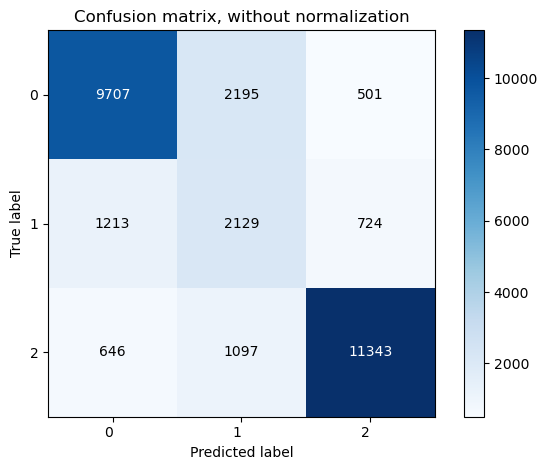

In [19]:
plot_confusion_matrix(preds_cb, y_test, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [20]:
%%time
text_pipe = Pipeline([
    ('colext', TextSelector(text_features)),
    ('tfidf', TfidfVectorizer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=400))
])



numeric_pipe = Pipeline([
    ('wordext', NumberSelector(numeric_features)),
    ('wscaler', StandardScaler())
])



feature_union = FeatureUnion([
    ('text', text_pipe),
    ('words', numeric_pipe)
])


classifier = Pipeline([
    ('features', feature_union),
    ('lrs', LogisticRegression(max_iter=500, multi_class='ovr'))
])
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)


CPU times: total: 3min 13s
Wall time: 27.9 s


In [21]:
macro_f1 = f1_score(y_test, preds, average='weighted')
print("F1 score:", macro_f1)

F1 score: 0.7779690448179052


Confusion matrix, without normalization


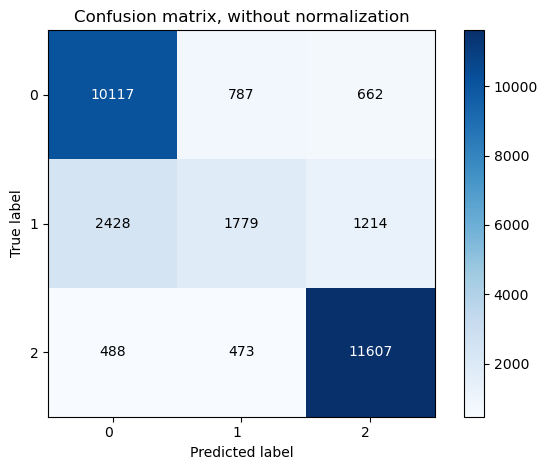

In [22]:
plot_confusion_matrix(y_test, preds, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [23]:
%%time
tfidf_vectorizer = TfidfVectorizer()
naive_bayes_classifier =  MultinomialNB(alpha=0.1)

text_naive_bayes = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('naive_bayes', naive_bayes_classifier),
])
text_naive_bayes.fit(X_train['cleaned_text'], y_train)

y_pred = text_naive_bayes.predict(X_test['cleaned_text'])

f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 score:", f1)

F1 score: 0.7538652833760523
CPU times: total: 3.98 s
Wall time: 3.98 s


Confusion matrix, without normalization


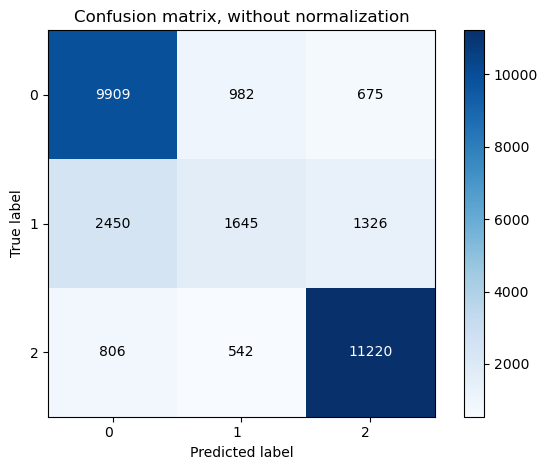

In [24]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plt.show()